<a href="https://colab.research.google.com/github/MohammadAghaei1/Plantdoc-image-processing/blob/main/Plantdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset**

In [1]:
!git clone https://github.com/MohammadAghaei1/Plantdoc-image-processing

Cloning into 'Plantdoc-image-processing'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 62 (delta 15), reused 0 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (62/62), 75.92 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (5/5), done.


In [2]:
!unzip /content/Plantdoc-image-processing/Dataset/PlantDoc\ 416x416.zip

Archive:  /content/Plantdoc-image-processing/Dataset/PlantDoc 416x416.zip
 extracting: train/Faske%20Southern%20rust%20of%20corn_jpg.rf.016116db58617610bb259b2965f41589.jpg  
 extracting: train/Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b93a38d296.jpg  
 extracting: train/2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B1_jpg.rf.00584c9d14b6fda3086f9a482675d610.jpg  
 extracting: train/Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf4232b5392e3d3c8.jpg  
 extracting: train/24154194959_fd4b42edde_b_jpg.rf.0012f9978a300c5635840700fa784280.jpg  
 extracting: train/2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2e382cf11216938e6f49b7d65ed.jpg  
 extracting: train/Septoria_tomato_Margaret%20B_p8170755_0002_25004_jpg.rf.00ddfef2668a53da256f207f9b844782.jpg  
 extracting: train/d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017e4558f1b4baeadc32a13beb178a6e.jpg  
 extracting: train/Bacterial-spot-symptoms-on-pepper-leaves-for-web_jpg.rf.01bc16f3b7ba0e4c9fa8c07133a723c6.jpg  
 extracting: train/IMG_6029-00

In [3]:
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# **Data Preparation**

**Train folder**

In [4]:
annotation_path = '/content/train/_annotations.csv'

**Some lines have problem in their names so before reading csv should repair them**

In [5]:
problematic_lines = []
expected_cols = 8

with open(annotation_path, 'r') as f:
    reader = csv.reader(f)
    # Skip the header row
    header = next(reader)
    for i, row in enumerate(reader):
        if len(row) != expected_cols:
            problematic_lines.append((i + 2, row))

if problematic_lines:
    with open('problematic_lines.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Line Number', 'Problematic Row Content'])
        for line_num, row_content in problematic_lines:
            writer.writerow([line_num, ','.join(row_content)])

    print(f"Found {len(problematic_lines)} problematic lines. Details saved to 'problematic_lines.csv'.")
    print("Please review 'problematic_lines.csv' and fix the data in the original file.")
else:
    print("No problematic lines found in the annotation file.")

Found 34 problematic lines. Details saved to 'problematic_lines.csv'.
Please review 'problematic_lines.csv' and fix the data in the original file.


**All the rows was fixed but just 10 of them was the emtpy and they didnt have considrable informations**

In [6]:
ANNOTATIONS = Path(annotation_path)
ENCODING    = "utf-8-sig"
OUT_CLEAN   = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_clean.csv")
OUT_BAD     = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_unfixable.csv")
EXPECTED_HEADER = ["filename","width","height","class","xmin","ymin","xmax","ymax"]


def is_int_token(s: str) -> bool:
    s = s.strip()
    if s.startswith(("+","-")): s = s[1:]
    return s.isdigit()

def first_consecutive_int_pair(tokens):
    """return index i where tokens[i] and tokens[i+1] are both ints; else None"""
    for i in range(len(tokens) - 1):
        if is_int_token(tokens[i]) and is_int_token(tokens[i+1]):
            return i
    return None

def rebuild_row(tokens):
    """
    tokens: list obtained by naive comma split via csv.reader
    returns (ok, row_or_reason)
    row format: [filename,width,height,class,xmin,ymin,xmax,ymax]
    """
    toks = [t.strip() for t in tokens if t is not None]

    # 1) locate width,height as the first consecutive int pair
    w_idx = first_consecutive_int_pair(toks)
    if w_idx is None:
        return False, "no consecutive width,height integers found"

    filename = ",".join(toks[:w_idx]).strip().strip('"')
    width, height = toks[w_idx], toks[w_idx + 1]
    rest = toks[w_idx + 2:]

    # Need at least 5 tokens after height (some class + 4 bbox ints)
    if len(rest) < 5:
        return False, "not enough fields after height"

    # 2) pick the LAST 4 integer tokens in 'rest' -> bbox
    bbox_indices = []
    for j in range(len(rest) - 1, -1, -1):
        if is_int_token(rest[j]):
            bbox_indices.append(j)
            if len(bbox_indices) == 4:
                break
    if len(bbox_indices) != 4:
        return False, "could not find 4 bbox integers in tail"
    bbox_indices.sort()
    xmin, ymin, xmax, ymax = [rest[k] for k in bbox_indices]

    # 3) class = everything between height and earliest bbox int
    class_tokens = rest[:bbox_indices[0]]
    if not class_tokens:
        return False, "class field missing"
    class_name = ",".join(class_tokens).strip().strip('"')

    return True, [filename, width, height, class_name, xmin, ymin, xmax, ymax]

def main():
    fixed, bad = [], []

    with ANNOTATIONS.open(encoding=ENCODING, newline="") as f:
        rdr = csv.reader(f)
        _ = next(rdr, None)  # skip original header if present
        for row in rdr:
            ok, out = rebuild_row(row)
            if ok:
                fixed.append(out)
            else:
                bad.append({"reason": out, "raw": ",".join(row)})

    # Write clean file
    with OUT_CLEAN.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(EXPECTED_HEADER)
        w.writerows(fixed)

    # Write any unfixable rows for manual check
    with OUT_BAD.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(["reason","raw_line"])
        for br in bad:
            w.writerow([br["reason"], br["raw"]])

    print(f" Clean rows written: {len(fixed)} -> {OUT_CLEAN}")
    print(f" Unfixable empty rows: {len(bad)} -> {OUT_BAD}")

if __name__ == "__main__":
    main()


 Clean rows written: 8353 -> /content/train/_annotations_clean.csv
 Unfixable empty rows: 10 -> /content/train/_annotations_unfixable.csv


In [7]:
annotation = pd.read_csv('/content/train/_annotations_clean.csv')

In [8]:
annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8353 non-null   object
 1   width     8353 non-null   int64 
 2   height    8353 non-null   int64 
 3   class     8353 non-null   object
 4   xmin      8353 non-null   int64 
 5   ymin      8353 non-null   int64 
 6   xmax      8353 non-null   int64 
 7   ymax      8353 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 522.2+ KB


**Put all images in train fodler to train/images**

In [9]:
import os
import shutil

source_dir = '/content/train'
destination_dir = '/content/train/images'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

moved_count = 0
for filename in all_files:
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if the file is a file (not a directory) and if it has a .jpg extension
    if os.path.isfile(source_path) and filename.lower().endswith('.jpg'):
        try:
            shutil.move(source_path, destination_path)
            moved_count += 1
        except Exception as e:
            print(f"Error moving {filename}: {e}")

print(f"Moved {moved_count} image files from {source_dir} to {destination_dir}")

Moved 2328 image files from /content/train to /content/train/images


**Check all unique names in annotation file to be in train folder**

In [10]:
import os
import pandas as pd
from pathlib import Path

# Load the cleaned training annotations CSV file
cleaned_annotations_path = '/content/train/_annotations_clean.csv'
cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

# Get the set of unique filenames from the CSV
csv_filenames = set(cleaned_annotation_df['filename'].unique())

# Get the set of image filenames from the directory
train_images_dir = '/content/train/images'
# List files in the directory and get their base names
image_files = set([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])


# Find the filenames that are in the CSV but not in the image directory
missing_images_in_directory = list(csv_filenames - image_files)

if missing_images_in_directory:
    print(f"Found {len(missing_images_in_directory)} filenames in '{cleaned_annotations_path}' that are NOT in '{train_images_dir}':")
    for filename in missing_images_in_directory:
        print(filename)
else:
    print("All unique filenames in the CSV have corresponding image files in the directory.")

All unique filenames in the CSV have corresponding image files in the directory.


**Check all the images in train folder to be in csv file**

In [11]:
import os
import pandas as pd

# Load the cleaned training annotations CSV file
cleaned_annotations_path = '/content/train/_annotations_clean.csv'
cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

# Get the set of unique filenames from the CSV
csv_filenames = set(cleaned_annotation_df['filename'].unique())

# Get the set of image filenames from the directory
train_images_dir = '/content/train/images'
image_files = set([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])

# Find the filenames that are in the image directory but not in the CSV
images_only_in_directory = list(image_files - csv_filenames)

# Calculate the number of matches
matching_files_count = len(image_files) - len(images_only_in_directory)

print(f"Number of matching image files in '{train_images_dir}' and unique filenames in '{cleaned_annotations_path}': {matching_files_count}")


if images_only_in_directory:
    print(f"\nFound {len(images_only_in_directory)} image files in '{train_images_dir}' that are NOT in '{cleaned_annotations_path}':")
    for filename in images_only_in_directory:
        print(filename)
else:
    print("All image files in the directory have corresponding unique filenames in the CSV.")

Number of matching image files in '/content/train/images' and unique filenames in '/content/train/_annotations_clean.csv': 2318

Found 10 image files in '/content/train/images' that are NOT in '/content/train/_annotations_clean.csv':
tomato_D4a-TobRingspotVirus-1000077_zoom_jpg.rf.2e3bf56fca79319caad79756a5a3489f.jpg
aquilegia-powdery-mildew-erysiphe-aquilegiae-on-columbine-leaves-bga5xr_jpg.rf.bd049474ad6eb0ee96506e9b2a2771ac.jpg
raspberries_jpg.rf.6f265fc0cc6e20357544cda8c1e08794.jpg
Black+Raspberry+Leaves+3_jpg.rf.a5118930e06e0d086213803cfdda04b3.jpg
Hydrangea+%2527Claudie%2527%252C+Powdery+Mildew_JPG_jpg.rf.241a2ba81fae4dd8f4d42a639bf4c542.jpg
pm1_600px_jpg.rf.cd599fa610030885978e3f8741b8eba8.jpg
powdery-mildew-erysiphe-plantani-on-young-sycamore-leaf-b372wn_jpg.rf.9f2fd157b98d7080ee62fda831e913e9.jpg
Downy%20mildew_JPG_jpg.rf.5cd0d81448f536b690c687fe43801ad8.jpg
270412tglr-wild-strawberry-flowers-and-leaf-patch_jpg.rf.11e3d6fa8e0828ac716e6e40f92ebd6b.jpg
raspberry-db_jpg.rf.b3eabf

**Delete the images that their name are not exist in csv file**

In [12]:
import os

images_to_delete = [
    'powdery-mildew-erysiphe-plantani-on-young-sycamore-leaf-b372wn_jpg.rf.9f2fd157b98d7080ee62fda831e913e9.jpg',
    'raspberry-db_jpg.rf.b3eabfd7a40d314ed0bd68e867f3bf6b.jpg',
    'aquilegia-powdery-mildew-erysiphe-aquilegiae-on-columbine-leaves-bga5xr_jpg.rf.bd049474ad6eb0ee96506e9b2a2771ac.jpg',
    'Black+Raspberry+Leaves+3_jpg.rf.a5118930e06e0d086213803cfdda04b3.jpg',
    '270412tglr-wild-strawberry-flowers-and-leaf-patch_jpg.rf.11e3d6fa8e0828ac716e6e40f92ebd6b.jpg',
    'tomato_D4a-TobRingspotVirus-1000077_zoom_jpg.rf.2e3bf56fca79319caad79756a5a3489f.jpg',
    'pm1_600px_jpg.rf.cd599fa610030885978e3f8741b8eba8.jpg',
    'raspberries_jpg.rf.6f265fc0cc6e20357544cda8c1e08794.jpg',
    'Downy%20mildew_JPG_jpg.rf.5cd0d81448f536b690c687fe43801ad8.jpg',
    'Hydrangea+%2527Claudie%2527%252C+Powdery+Mildew_JPG_jpg.rf.241a2ba81fae4dd8f4d42a639bf4c542.jpg' # Added the 10th image from the previous output
]

train_images_dir = '/content/train/images'
deleted_count = 0

print(f"Attempting to delete {len(images_to_delete)} image files from {train_images_dir}")

for filename in images_to_delete:
    image_path = os.path.join(train_images_dir, filename)
    if os.path.exists(image_path):
        try:
            os.remove(image_path)
            deleted_count += 1
            print(f"Deleted: {filename}")
        except Exception as e:
            print(f"Error deleting {filename}: {e}")
    else:
        print(f"File not found, skipping: {filename}")

print(f"\nFinished deleting images. Successfully deleted {deleted_count} files.")

Attempting to delete 10 image files from /content/train/images
Deleted: powdery-mildew-erysiphe-plantani-on-young-sycamore-leaf-b372wn_jpg.rf.9f2fd157b98d7080ee62fda831e913e9.jpg
Deleted: raspberry-db_jpg.rf.b3eabfd7a40d314ed0bd68e867f3bf6b.jpg
Deleted: aquilegia-powdery-mildew-erysiphe-aquilegiae-on-columbine-leaves-bga5xr_jpg.rf.bd049474ad6eb0ee96506e9b2a2771ac.jpg
Deleted: Black+Raspberry+Leaves+3_jpg.rf.a5118930e06e0d086213803cfdda04b3.jpg
Deleted: 270412tglr-wild-strawberry-flowers-and-leaf-patch_jpg.rf.11e3d6fa8e0828ac716e6e40f92ebd6b.jpg
Deleted: tomato_D4a-TobRingspotVirus-1000077_zoom_jpg.rf.2e3bf56fca79319caad79756a5a3489f.jpg
Deleted: pm1_600px_jpg.rf.cd599fa610030885978e3f8741b8eba8.jpg
Deleted: raspberries_jpg.rf.6f265fc0cc6e20357544cda8c1e08794.jpg
Deleted: Downy%20mildew_JPG_jpg.rf.5cd0d81448f536b690c687fe43801ad8.jpg
Deleted: Hydrangea+%2527Claudie%2527%252C+Powdery+Mildew_JPG_jpg.rf.241a2ba81fae4dd8f4d42a639bf4c542.jpg

Finished deleting images. Successfully deleted 10

In [13]:
import os

train_image_count = len(os.listdir('/content/train/images'))
print(f"Number of images in training set: {train_image_count}")


Number of images in training set: 2318


**Checking duplicate items in both train image folder and also csv annotation file**

In [14]:
import os
import hashlib

def hash_file(filepath):
    """Calculates the SHA256 hash of a file."""
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as f:
        while True:
            chunk = f.read(4096)
            if not chunk:
                break
            hasher.update(chunk)
    return hasher.hexdigest()

train_images_dir = '/content/train/images'
image_files = [os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]

hashes = {}
duplicates = []

print(f"Checking for duplicate images in {train_images_dir}...")

for filepath in image_files:
    try:
        file_hash = hash_file(filepath)
        if file_hash in hashes:
            duplicates.append((filepath, hashes[file_hash]))
        else:
            hashes[file_hash] = filepath
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")

if duplicates:
    print("\nFound duplicate images:")
    for file1, file2 in duplicates:
        print(f"- {file1} is a duplicate of {file2}")
else:
    print("\nNo duplicate images found.")

Checking for duplicate images in /content/train/images...

No duplicate images found.


In [15]:
duplicate_rows = annotation.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


**Checking problematic bounding boxes in csv file**

In [20]:
import pandas as pd
from pathlib import Path
from urllib.parse import unquote

# --- paths ---
CSV = "/content/train/_annotations_clean.csv"   # your CSV
OUT = Path("/content/_report"); OUT.mkdir(parents=True, exist_ok=True)

# --- read & normalize columns ---
df = pd.read_csv(CSV)
df.columns = [c.strip().lower() for c in df.columns]
required = {"filename","width","height","class","xmin","ymin","xmax","ymax"}
missing  = required - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# filename → basename only
df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)

# numeric conversion
for c in ["width","height","xmin","ymin","xmax","ymax"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- checks ---
EPS = 1e-6
MIN_AREA_PCT = 1e-4  # 0.01% of image

W, H = df["width"], df["height"]
wpx  = df["xmax"] - df["xmin"]
hpx  = df["ymax"] - df["ymin"]
area = wpx * hpx

df["_bad_wh"]     = (W<=0) | (H<=0) | W.isna() | H.isna()
df["_oob"]        = (df["xmin"]<-EPS) | (df["ymin"]<-EPS) | (df["xmax"]>W+EPS) | (df["ymax"]>H+EPS)
df["_zero_neg"]   = (wpx<=EPS) | (hpx<=EPS)
df["_very_small"] = (area / (W*H + EPS)) < MIN_AREA_PCT
df["_non_numeric"]= df[["xmin","ymin","xmax","ymax","width","height"]].isna().any(axis=1)

# rows with any issue
mask = df[["_bad_wh","_oob","_zero_neg","_very_small","_non_numeric"]].any(axis=1)
bad  = df.loc[mask, ["__file","class","width","height","xmin","ymin","xmax","ymax",
                     "_oob","_zero_neg","_very_small","_non_numeric"]]

# --- reports ---
bad_path   = OUT/"csv_bbox_qc.csv"
perimg_path= OUT/"csv_bbox_qc_per_image.csv"

bad.to_csv(bad_path, index=False)

# per-image summary (which issues appear in each image)
if len(bad):
    per_img = (bad.groupby("__file")[["_oob","_zero_neg","_very_small","_non_numeric"]]
               .max().reset_index())
    per_img["issues_in_image"] = per_img[["_oob","_zero_neg","_very_small","_non_numeric"]].sum(axis=1)
    per_img.sort_values("issues_in_image", ascending=False).to_csv(perimg_path, index=False)

# --- pretty summary ---
rows     = len(df)
images   = df["__file"].nunique()
bad_rows = len(bad)
ok_rows  = rows - bad_rows

def pct(n, d):
    return f"{n} ({0 if d==0 else 100*n/d:.2f}%)"

issue_counts = {
    "out_of_bounds": int(df["_oob"].sum()),
    "zero_or_negative": int(df["_zero_neg"].sum()),
    "very_small": int(df["_very_small"].sum()),
    "non_numeric": int(df["_non_numeric"].sum()),
    "bad_width_height": int(df["_bad_wh"].sum()),
}

print("\n" + "="*62)
print("CSV BBox QC — Summary")
print("="*62)
print(f"Rows (boxes): {rows}")
print(f"Images:       {images}")
print(f"OK rows:      {pct(ok_rows, rows)}")
print(f"Bad rows:     {pct(bad_rows, rows)}")
print("-"*62)
for k,v in issue_counts.items():
    print(f"{k:>18}: {pct(v, rows)}")
print("-"*62)
print(f"Report (rows) -> {bad_path}")
if bad_rows:
    print(f"Report (per-image) -> {perimg_path}")
    print("\nTop 10 problematic rows:")
    print(bad.head(10).to_string(index=False))
else:
    print("No problematic rows found ")



CSV BBox QC — Summary
Rows (boxes): 8353
Images:       2318
OK rows:      8353 (100.00%)
Bad rows:     0 (0.00%)
--------------------------------------------------------------
     out_of_bounds: 0 (0.00%)
  zero_or_negative: 0 (0.00%)
        very_small: 0 (0.00%)
       non_numeric: 0 (0.00%)
  bad_width_height: 0 (0.00%)
--------------------------------------------------------------
Report (rows) -> /content/_report/csv_bbox_qc.csv
No problematic rows found 


**Checking the bounding boxes sizes that are usefull in preprocessing**

In [22]:
import pandas as pd
from pathlib import Path
from urllib.parse import unquote
import math

# ---- inputs ----
CSV = "/content/train/_annotations_clean.csv"
OUT = Path("/content/_report"); OUT.mkdir(parents=True, exist_ok=True)
IMG_SIZE = 416  # only used to show an approximate square side in pixels

# ---- load ----
df = pd.read_csv(CSV)
df.columns = [c.strip().lower() for c in df.columns]
for c in ["width","height","xmin","ymin","xmax","ymax"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

valid = df.dropna(subset=["width","height","xmin","ymin","xmax","ymax"]).copy()
valid = valid[(valid["width"]>0) & (valid["height"]>0)]
area  = ((valid["xmax"]-valid["xmin"]) * (valid["ymax"]-valid["ymin"])) / (valid["width"]*valid["height"])

# ---- thresholds ----
TINY, SMALL, MEDIUM = 0.0025, 0.01, 0.10  # 0.25%, 1%, 10%

bins = {
    "tiny":   (area < TINY),
    "small":  (area >= TINY) & (area < SMALL),
    "medium": (area >= SMALL) & (area < MEDIUM),
    "large":  (area >= MEDIUM),
}
total = int(area.shape[0])
pct = lambda n: (0 if total==0 else 100*n/total)

def side_px(frac): return int(math.sqrt(max(frac,0))*IMG_SIZE)

rows = []
for name, mask in bins.items():
    cnt = int(mask.sum())
    rng = {"tiny":f"[0,{TINY:.4f})","small":f"[{TINY:.4f},{SMALL:.4f})",
           "medium":f"[{SMALL:.4f},{MEDIUM:.4f})","large":f"[{MEDIUM:.4f},1.0000]"}[name]
    if name=="tiny":   side="≤"+str(side_px(TINY))+"px"
    elif name=="small":side=f"{side_px(TINY)}–{side_px(SMALL)}px"
    elif name=="medium":side=f"{side_px(SMALL)}–{side_px(MEDIUM)}px"
    else:              side="≥"+str(side_px(MEDIUM))+"px"
    rows.append({"bucket":name, "range":rng, "count":cnt, "percent":f"{pct(cnt):.1f}%", "≈square_side@416":side})

dist_df = pd.DataFrame(rows, columns=["bucket","range","count","percent","≈square_side@416"])
dist_df.to_csv(OUT/"size_distribution.csv", index=False)

# ---- single concise print ----
print("BBox size distribution (normalized area) — total instances:", total)
print(dist_df.to_string(index=False))
print("Saved:", OUT/"size_distribution.csv")


BBox size distribution (normalized area) — total instances: 8353
bucket           range  count percent ≈square_side@416
  tiny      [0,0.0025)     66    0.8%            ≤20px
 small [0.0025,0.0100)    555    6.6%          20–41px
medium [0.0100,0.1000)   4701   56.3%         41–131px
 large [0.1000,1.0000]   3031   36.3%           ≥131px
Saved: /content/_report/size_distribution.csv


# **EDA**

In [ ]:
num_classes = annotation['class'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 30


class
Apple Scab Leaf                          83
Apple leaf                               82
Apple rust leaf                          78
Bell_pepper leaf                         53
Bell_pepper leaf spot                    62
Blueberry leaf                          103
Cherry leaf                              47
Corn Gray leaf spot                      61
Corn leaf blight                        178
Corn rust leaf                          106
Peach leaf                              101
Potato leaf                               3
Potato leaf early blight                106
Potato leaf late blight                  96
Raspberry leaf                          112
Soyabean leaf                            57
Soybean leaf                              1
Squash Powdery mildew leaf              124
Strawberry leaf                          87
Tomato Early blight leaf                 79
Tomato Septoria leaf spot               137
Tomato leaf                              65
Tomato leaf bacterial spot

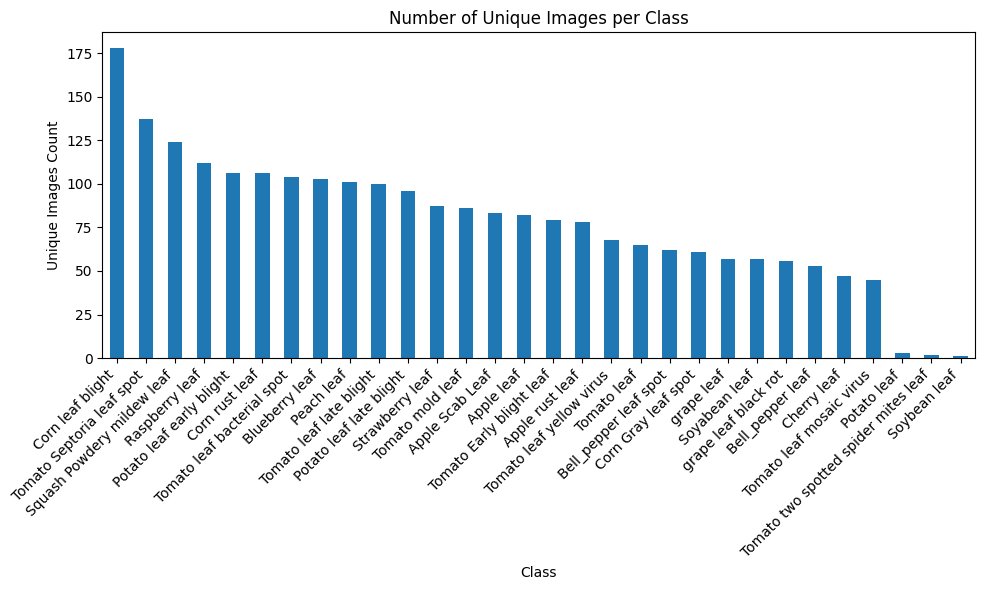

In [ ]:
img_per_class = annotation.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))ُ
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
annotation['class'] = annotation['class'].replace('Soybean leaf', 'Soyabean leaf')
print("Changed 'Soybean leaf' to 'Soyabean leaf'")

Changed 'Soybean leaf' to 'Soyabean leaf'


class
Blueberry leaf                          816
Tomato leaf yellow virus                759
Peach leaf                              579
Raspberry leaf                          539
Strawberry leaf                         443
Tomato Septoria leaf spot               402
Tomato leaf                             373
Corn leaf blight                        356
Bell_pepper leaf                        312
Potato leaf early blight                301
Tomato mold leaf                        279
Tomato leaf bacterial spot              266
Soyabean leaf                           261
Squash Powdery mildew leaf              248
Bell_pepper leaf spot                   248
Apple leaf                              237
Potato leaf late blight                 235
Tomato leaf mosaic virus                225
Cherry leaf                             220
grape leaf                              205
Tomato leaf late blight                 204
Tomato Early blight leaf                193
Apple rust leaf           

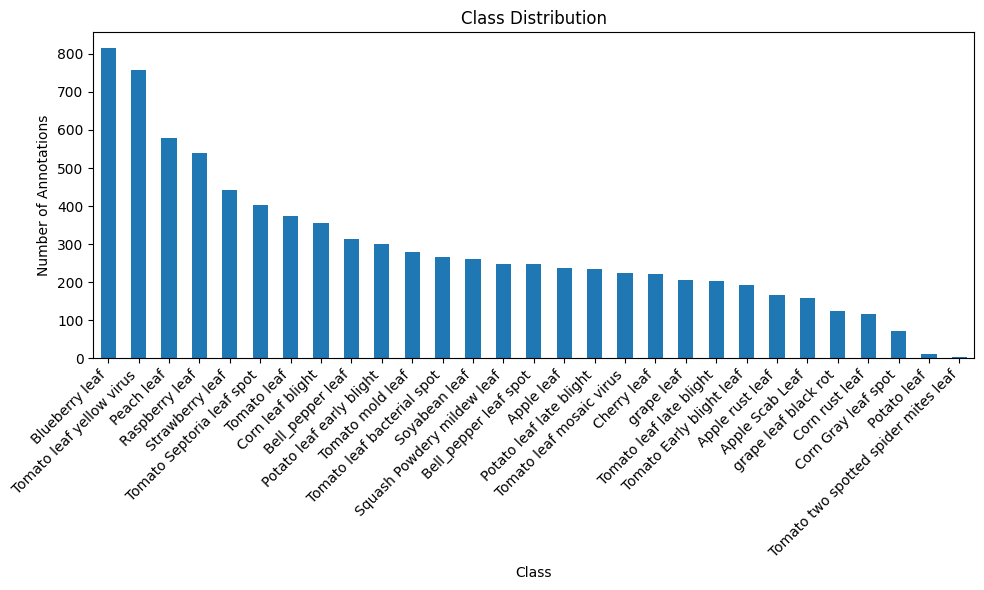

In [ ]:
# Count number of samples per class
class_counts = annotation['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
num_classes = annotation['class'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 29


In [ ]:
cell_name = "SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg"
annotation.loc[
    (annotation["filename"] == cell_name) &
    (annotation["class"] == "Tomato two spotted spider mites leaf"),
    "class"
] = "Tomato Early blight leaf"

print(f"Updated class for filename: {cell_name}")

Updated class for filename: SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg


class
Apple Scab Leaf                          83
Apple leaf                               82
Apple rust leaf                          78
Bell_pepper leaf                         53
Bell_pepper leaf spot                    62
Blueberry leaf                          103
Cherry leaf                              47
Corn Gray leaf spot                      61
Corn leaf blight                        178
Corn rust leaf                          106
Peach leaf                              101
Potato leaf                               3
Potato leaf early blight                106
Potato leaf late blight                  96
Raspberry leaf                          112
Soyabean leaf                            58
Squash Powdery mildew leaf              124
Strawberry leaf                          87
Tomato Early blight leaf                 79
Tomato Septoria leaf spot               137
Tomato leaf                              65
Tomato leaf bacterial spot              104
Tomato leaf late blight   

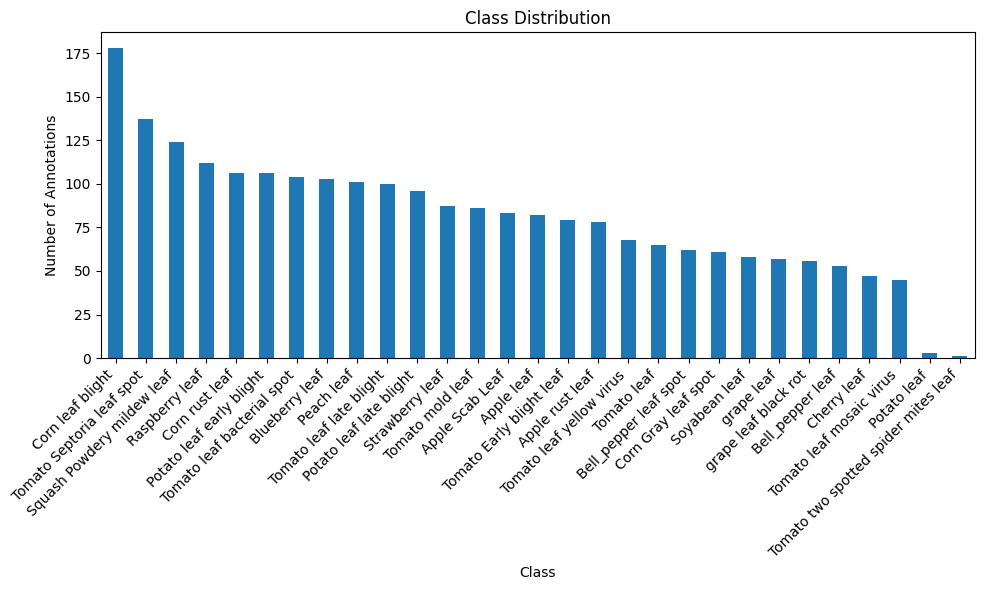

In [ ]:
class_counts = annotation.groupby("class")["filename"].nunique()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.sort_values(ascending=False).plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

class
Blueberry leaf                          816
Tomato leaf yellow virus                759
Peach leaf                              579
Raspberry leaf                          539
Strawberry leaf                         443
Tomato Septoria leaf spot               402
Tomato leaf                             373
Corn leaf blight                        356
Bell_pepper leaf                        312
Potato leaf early blight                301
Tomato mold leaf                        279
Tomato leaf bacterial spot              266
Soyabean leaf                           261
Squash Powdery mildew leaf              248
Bell_pepper leaf spot                   248
Apple leaf                              237
Potato leaf late blight                 235
Tomato leaf mosaic virus                225
Cherry leaf                             220
grape leaf                              205
Tomato leaf late blight                 204
Tomato Early blight leaf                194
Apple rust leaf           

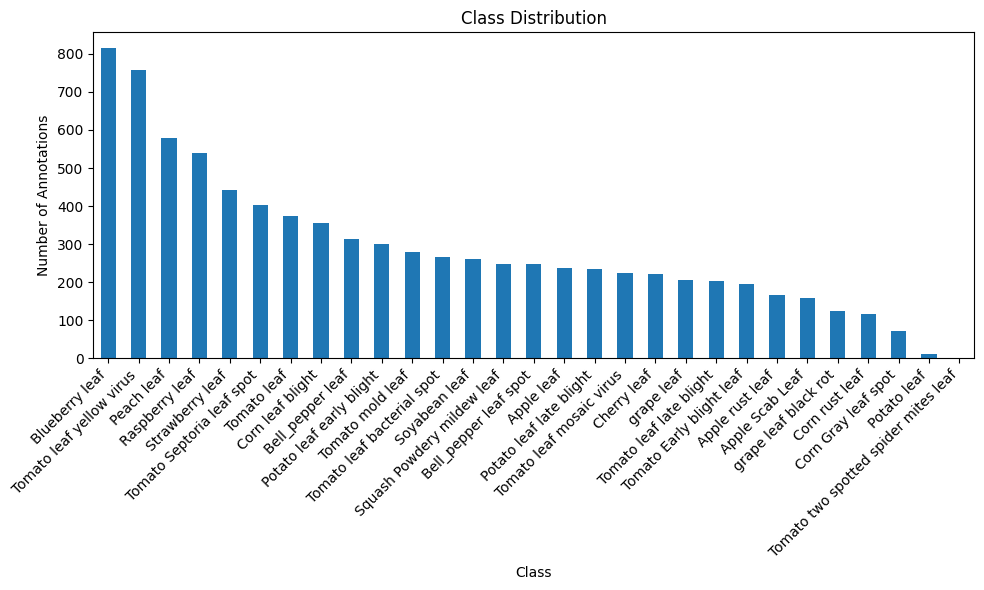

In [ ]:
# Count number of samples per class
class_counts = annotation['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Test folder checking**

In [ ]:
annotation_test = '/content/test/_annotations.csv'

In [ ]:
problematic_lines = []
expected_cols = 8

with open(annotation_test, 'r') as f:
    reader = csv.reader(f)
    # Skip the header row
    header = next(reader)
    for i, row in enumerate(reader):
        if len(row) != expected_cols:
            problematic_lines.append((i + 2, row))

if problematic_lines:
    with open('problematic_lines.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Line Number', 'Problematic Row Content'])
        for line_num, row_content in problematic_lines:
            writer.writerow([line_num, ','.join(row_content)])

    print(f"Found {len(problematic_lines)} problematic lines. Details saved to 'problematic_lines.csv'.")
    print("Please review 'problematic_lines.csv' and fix the data in the original file.")
else:
    print("No problematic lines found in the annotation file.")

Found 2 problematic lines. Details saved to 'problematic_lines.csv'.
Please review 'problematic_lines.csv' and fix the data in the original file.


In [ ]:
ANNOTATIONS = Path(annotation_test)
ENCODING    = "utf-8-sig"
OUT_CLEAN   = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_clean.csv")
OUT_BAD     = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_unfixable.csv")
EXPECTED_HEADER = ["filename","width","height","class","xmin","ymin","xmax","ymax"]


def is_int_token(s: str) -> bool:
    s = s.strip()
    if s.startswith(("+","-")): s = s[1:]
    return s.isdigit()

def first_consecutive_int_pair(tokens):
    """return index i where tokens[i] and tokens[i+1] are both ints; else None"""
    for i in range(len(tokens) - 1):
        if is_int_token(tokens[i]) and is_int_token(tokens[i+1]):
            return i
    return None

def rebuild_row(tokens):
    """
    tokens: list obtained by naive comma split via csv.reader
    returns (ok, row_or_reason)
    row format: [filename,width,height,class,xmin,ymin,xmax,ymax]
    """
    toks = [t.strip() for t in tokens if t is not None]

    # 1) locate width,height as the first consecutive int pair
    w_idx = first_consecutive_int_pair(toks)
    if w_idx is None:
        return False, "no consecutive width,height integers found"

    filename = ",".join(toks[:w_idx]).strip().strip('"')
    width, height = toks[w_idx], toks[w_idx + 1]
    rest = toks[w_idx + 2:]

    # Need at least 5 tokens after height (some class + 4 bbox ints)
    if len(rest) < 5:
        return False, "not enough fields after height"

    # 2) pick the LAST 4 integer tokens in 'rest' -> bbox
    bbox_indices = []
    for j in range(len(rest) - 1, -1, -1):
        if is_int_token(rest[j]):
            bbox_indices.append(j)
            if len(bbox_indices) == 4:
                break
    if len(bbox_indices) != 4:
        return False, "could not find 4 bbox integers in tail"
    bbox_indices.sort()
    xmin, ymin, xmax, ymax = [rest[k] for k in bbox_indices]

    # 3) class = everything between height and earliest bbox int
    class_tokens = rest[:bbox_indices[0]]
    if not class_tokens:
        return False, "class field missing"
    class_name = ",".join(class_tokens).strip().strip('"')

    return True, [filename, width, height, class_name, xmin, ymin, xmax, ymax]

def main():
    fixed, bad = [], []

    with ANNOTATIONS.open(encoding=ENCODING, newline="") as f:
        rdr = csv.reader(f)
        _ = next(rdr, None)  # skip original header if present
        for row in rdr:
            ok, out = rebuild_row(row)
            if ok:
                fixed.append(out)
            else:
                bad.append({"reason": out, "raw": ",".join(row)})

    # Write clean file
    with OUT_CLEAN.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(EXPECTED_HEADER)
        w.writerows(fixed)

    # Write any unfixable rows for manual check
    with OUT_BAD.open("w", newline="", encoding=ENCODING) as f:
        w = csv.writer(f)
        w.writerow(["reason","raw_line"])
        for br in bad:
            w.writerow([br["reason"], br["raw"]])

    print(f" Clean rows written: {len(fixed)} -> {OUT_CLEAN}")
    print(f" Unfixable empty rows: {len(bad)} -> {OUT_BAD}")

if __name__ == "__main__":
    main()

 Clean rows written: 454 -> /content/test/_annotations_clean.csv
 Unfixable empty rows: 1 -> /content/test/_annotations_unfixable.csv


In [ ]:
annotation_test_clean = pd.read_csv('/content/test/_annotations_clean.csv')

In [ ]:
annotation_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  454 non-null    object
 1   width     454 non-null    int64 
 2   height    454 non-null    int64 
 3   class     454 non-null    object
 4   xmin      454 non-null    int64 
 5   ymin      454 non-null    int64 
 6   xmax      454 non-null    int64 
 7   ymax      454 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 28.5+ KB


In [ ]:
base_dir = Path("/content/test")

missing_files = [
    f for f in annotation_test_clean["filename"].unique()
    if not (base_dir / f).exists()
]

if missing_files:
    pd.Series(missing_files, name="filename").to_csv("missing_images.csv", index=False)
    print(f"⚠ Found {len(missing_files)} missing files. Saved to missing_images.csv")
else:
    print(" All files exist. No action needed.")


 All files exist. No action needed.


In [ ]:
duplicate_rows = annotation_test_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [ ]:
num_classes = annotation_test_clean['class'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 27


class
Apple Scab Leaf               10
Apple leaf                     9
Apple rust leaf               10
Bell_pepper leaf               8
Bell_pepper leaf spot          9
Blueberry leaf                11
Cherry leaf                   10
Corn Gray leaf spot            4
Corn leaf blight              12
Corn rust leaf                10
Peach leaf                     9
Potato leaf early blight       8
Potato leaf late blight        8
Raspberry leaf                 7
Soyabean leaf                  8
Squash Powdery mildew leaf     8
Strawberry leaf                8
Tomato Early blight leaf       9
Tomato Septoria leaf spot     11
Tomato leaf                    8
Tomato leaf bacterial spot     9
Tomato leaf late blight       10
Tomato leaf mosaic virus      10
Tomato leaf yellow virus       6
Tomato mold leaf               6
grape leaf                    12
grape leaf black rot           8
Name: filename, dtype: int64


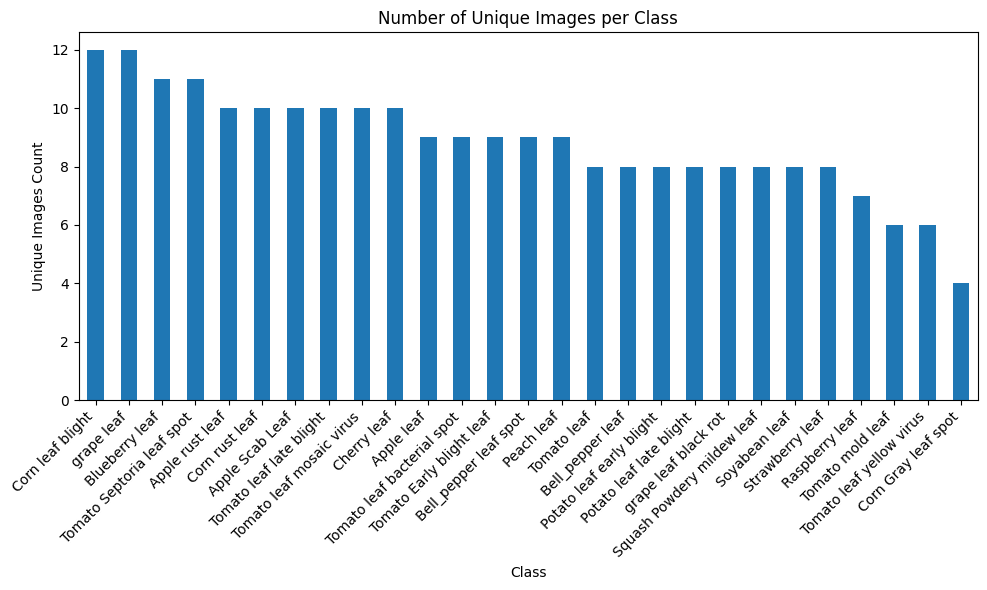

In [ ]:
img_per_class = annotation_test_clean.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


class
Tomato leaf yellow virus      42
Tomato leaf mosaic virus      36
Strawberry leaf               30
Tomato leaf                   27
Tomato Septoria leaf spot     24
Blueberry leaf                22
Soyabean leaf                 20
Tomato Early blight leaf      19
Cherry leaf                   19
Potato leaf early blight      17
Raspberry leaf                17
Tomato mold leaf              16
Bell_pepper leaf spot         15
grape leaf                    15
Tomato leaf bacterial spot    14
Tomato leaf late blight       14
Apple Scab Leaf               13
Corn leaf blight              12
Apple rust leaf               11
Bell_pepper leaf              11
Potato leaf late blight       10
Peach leaf                    10
Apple leaf                    10
Corn rust leaf                10
Squash Powdery mildew leaf     8
grape leaf black rot           8
Corn Gray leaf spot            4
Name: count, dtype: int64


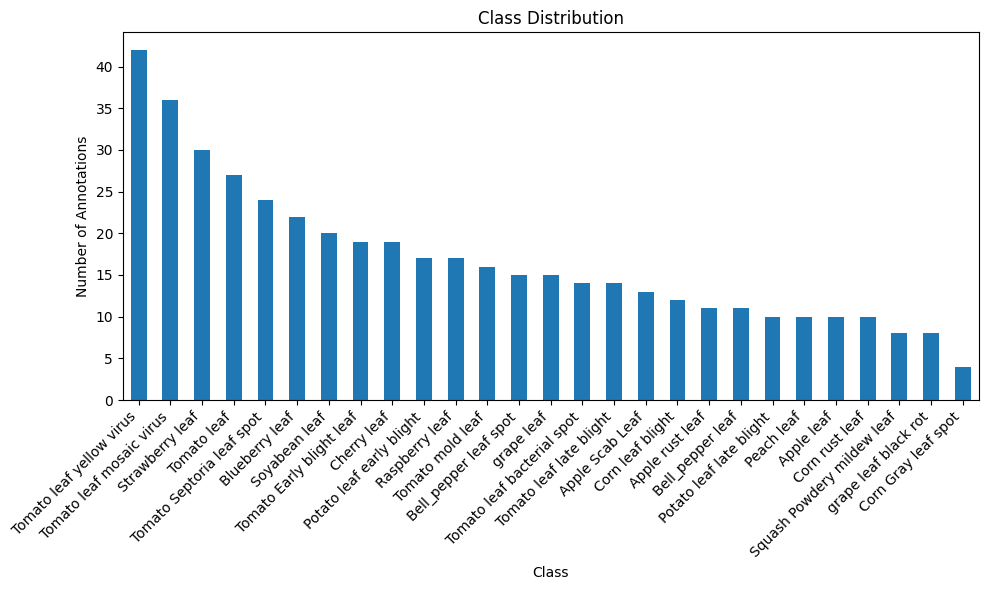

In [ ]:
# Count number of samples per class
class_counts = annotation_test_clean['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#finding same filenames in both test and train dataset
common_filenames = set(annotation['filename']).intersection(set(annotation_test_clean['filename']))

if common_filenames:
    print(f"Found {len(common_filenames)} common filenames:")
    for filename in list(common_filenames):
        print(filename)
else:
    print("No common filenames found in annotation and annotation_test_clean.")

No common filenames found in annotation and annotation_test_clean.


# **Data Preprocessing**

In [ ]:
annotation = annotation[~annotation['class'].isin(['Tomato two spotted spider mites leaf', 'Potato leaf'])]

In [ ]:
annotation.to_csv('/content/train/_annotations_cleaned_image_checking.csv', index=False)
print("Filtered annotations saved to /content/train/_annotations_cleaned_filtered.csv")

Filtered annotations saved to /content/train/_annotations_cleaned_filtered.csv


class
Apple Scab Leaf                83
Apple leaf                     82
Apple rust leaf                78
Bell_pepper leaf               53
Bell_pepper leaf spot          62
Blueberry leaf                103
Cherry leaf                    47
Corn Gray leaf spot            61
Corn leaf blight              178
Corn rust leaf                106
Peach leaf                    101
Potato leaf early blight      106
Potato leaf late blight        96
Raspberry leaf                112
Soyabean leaf                  58
Squash Powdery mildew leaf    124
Strawberry leaf                87
Tomato Early blight leaf       79
Tomato Septoria leaf spot     137
Tomato leaf                    65
Tomato leaf bacterial spot    104
Tomato leaf late blight       100
Tomato leaf mosaic virus       45
Tomato leaf yellow virus       68
Tomato mold leaf               86
grape leaf                     57
grape leaf black rot           56
Name: filename, dtype: int64


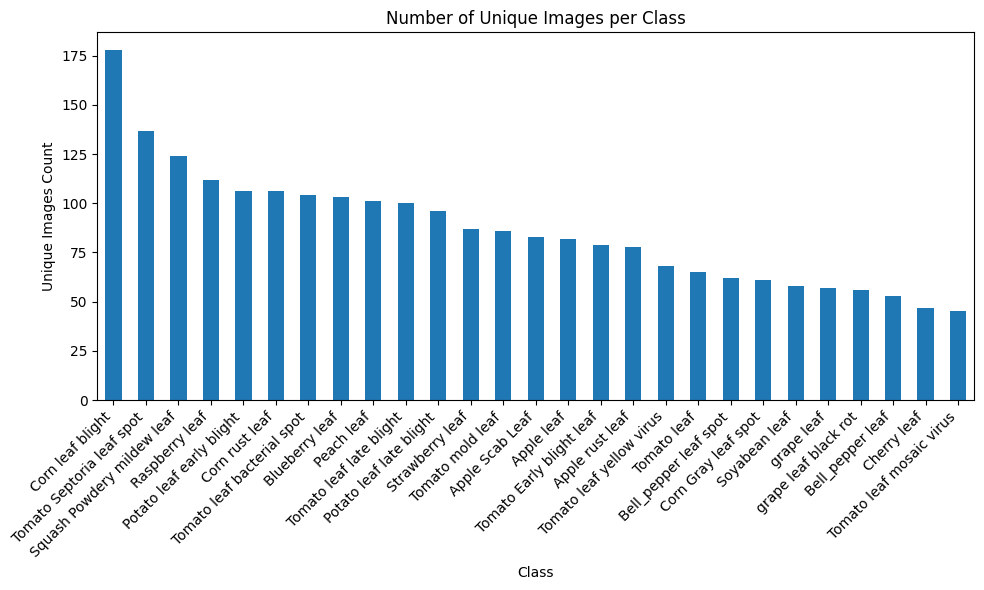

In [ ]:
img_per_class = annotation.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil

source_dir = '/content/test'
destination_dir = '/content/test/images'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

moved_count = 0
for filename in all_files:
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if the file is a file (not a directory) and if it has a .jpg extension
    if os.path.isfile(source_path) and filename.lower().endswith('.jpg'):
        try:
            shutil.move(source_path, destination_path)
            moved_count += 1
        except Exception as e:
            print(f"Error moving {filename}: {e}")

print(f"Moved {moved_count} image files from {source_dir} to {destination_dir}")

Moved 239 image files from /content/test to /content/test/images


**deleteeeeeeeeeeeeeeeeeeeeeeeeeee**

In [ ]:
convert_csv_to_yolo("/content/train/_annotations_cleaned_image_checking.csv", "/content/images_checking/labels")

✅ Done: wrote 2318 label files with 8341 boxes into: /content/images_checking/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


In [ ]:
from pathlib import Path
import glob, pandas as pd
from urllib.parse import unquote

CSV_PATH   = Path("/content/train/_annotations_cleaned_image_checking.csv")         # مسیر CSV خودت
IMGS_DIR   = Path("/content/train/images")            # پوشه‌ی تصاویر
LABELS_DIR = Path("/content/images_checking/labels")            # پوشه‌ی لیبل‌ها
REPORT_DIR = Path("/content/_report"); REPORT_DIR.mkdir(parents=True, exist_ok=True)

print("Paths set.")


Paths set.


In [ ]:
def list_images(img_dir: Path):
    pats = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    paths = []
    for p in pats:
        paths += glob.glob(str(img_dir/"**"/p), recursive=True)
    return [Path(p) for p in paths]

img_paths = list_images(IMGS_DIR)
img_stems_exact = {p.stem for p in img_paths}
lbl_stems_exact = {p.stem for p in LABELS_DIR.glob("*.txt")} | {p.stem for p in LABELS_DIR.glob("*.TXT")}

print(f"images: {len(img_paths)} | label files: {len(lbl_stems_exact)}")


images: 2328 | label files: 2319


In [ ]:
df = pd.read_csv(CSV_PATH)
df.columns = [str(c).strip().lower() for c in df.columns]

required = ["filename","width","height","class","xmin","ymin","xmax","ymax"]
missing_cols = [c for c in required if c not in df.columns]
if missing_cols:
    print("⚠️ Missing CSV columns:", missing_cols)

df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)
df["__stem"] = df["__file"].map(lambda x: Path(x).stem)

csv_stems = set(df["__stem"].tolist())
print("unique stems in CSV:", len(csv_stems))


unique stems in CSV: 2318


In [ ]:
images_without_label = sorted(img_stems_exact - lbl_stems_exact)
print("images without EXACT-NAME label:", len(images_without_label))
REPORT_DIR.joinpath("images_without_exact_label.txt").write_text("\n".join(images_without_label), encoding="utf-8")
print("→ saved to:", REPORT_DIR/"images_without_exact_label.txt")


images without EXACT-NAME label: 162
→ saved to: /content/_report/images_without_exact_label.txt


In [ ]:
images_not_in_csv = sorted(img_stems_exact - csv_stems)
print("images present on disk but MISSING in CSV:", len(images_not_in_csv))
REPORT_DIR.joinpath("images_missing_in_csv.txt").write_text("\n".join(images_not_in_csv), encoding="utf-8")
print("→ saved to:", REPORT_DIR/"images_missing_in_csv.txt")


images present on disk but MISSING in CSV: 162
→ saved to: /content/_report/images_missing_in_csv.txt


In [ ]:
csv_but_no_image = sorted(csv_stems - img_stems_exact)
print("CSV references with NO image file on disk:", len(csv_but_no_image))
REPORT_DIR.joinpath("csv_refs_without_image.txt").write_text("\n".join(csv_but_no_image), encoding="utf-8")
print("→ saved to:", REPORT_DIR/"csv_refs_without_image.txt")


CSV references with NO image file on disk: 152
→ saved to: /content/_report/csv_refs_without_image.txt


In [ ]:
bad_rows = []

for i, r in df.iterrows():
    try:
        W = float(r["width"]); H = float(r["height"])
        xmin = float(r["xmin"]); ymin = float(r["ymin"])
        xmax = float(r["xmax"]); ymax = float(r["ymax"])
    except Exception:
        bad_rows.append({"row": i, "stem": r.get("__stem","?"), "reason": "non-numeric"})
        continue

    # مقادیر نامعتبر
    if W <= 0 or H <= 0:
        bad_rows.append({"row": i, "stem": r["__stem"], "reason": "non-positive WH"})
        continue

    # خارج از تصویر؟
    oob = (xmin < 0) or (ymin < 0) or (xmax > W) or (ymax > H)
    # مساحت نامعتبر؟
    zero = (xmax <= xmin) or (ymax <= ymin)

    if oob or zero:
        reason = []
        if oob: reason.append("out-of-bounds")
        if zero: reason.append("zero/neg area")
        bad_rows.append({"row": i, "stem": r["__stem"], "reason": ", ".join(reason)})

import pandas as pd
bad_df = pd.DataFrame(bad_rows)
print("bad CSV rows:", len(bad_df))
bad_csv_path = REPORT_DIR/"csv_bad_rows.csv"
if len(bad_df):
    bad_df.to_csv(bad_csv_path, index=False)
    print("→ saved detailed list to:", bad_csv_path)
else:
    print("No bad rows detected.")


bad CSV rows: 0
No bad rows detected.


In [ ]:
summary = f"""
Summary
-------
images: {len(img_paths)}
labels (.txt): {len(lbl_stems_exact)}
unique stems in CSV: {len(csv_stems)}

1) images without EXACT-NAME label: {len(images_without_label)}
   -> {REPORT_DIR/'images_without_exact_label.txt'}

2) images present on disk but MISSING in CSV: {len(images_not_in_csv)}
   -> {REPORT_DIR/'images_missing_in_csv.txt'}

3) CSV stems with NO image on disk: {len(csv_but_no_image)}
   -> {REPORT_DIR/'csv_refs_without_image.txt'}

4) bad CSV rows (oob / zero area / non-numeric): {len(bad_rows)}
   -> {REPORT_DIR/'csv_bad_rows.csv'}
"""
print(summary)



Summary
-------
images: 2328
labels (.txt): 2319
unique stems in CSV: 2318

1) images without EXACT-NAME label: 162
   -> /content/_report/images_without_exact_label.txt

2) images present on disk but MISSING in CSV: 162
   -> /content/_report/images_missing_in_csv.txt

3) CSV stems with NO image on disk: 152
   -> /content/_report/csv_refs_without_image.txt

4) bad CSV rows (oob / zero area / non-numeric): 0
   -> /content/_report/csv_bad_rows.csv



In [ ]:
import os
import pandas as pd

# Load the cleaned training annotations CSV file
cleaned_annotations_path = '/content/train/_annotations_cleaned_image_checking.csv'
cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

# Count the number of unique filenames in the DataFrame
unique_filenames_count = cleaned_annotation_df['filename'].nunique()

# Count the number of image files in the training images directory
train_images_dir = '/content/train/images'
image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
train_image_count = len(image_files)

print(f"Number of unique filenames in '{cleaned_annotations_path}': {unique_filenames_count}")
print(f"Number of image files in '{train_images_dir}': {train_image_count}")

if unique_filenames_count == train_image_count:
    print("The number of unique filenames in the CSV matches the number of image files in the directory.")
else:
    print("The number of unique filenames in the CSV DOES NOT match the number of image files in the directory.")

Number of unique filenames in '/content/train/_annotations_cleaned_image_checking.csv': 2318
Number of image files in '/content/train/images': 2328
The number of unique filenames in the CSV DOES NOT match the number of image files in the directory.


In [ ]:
import os
import pandas as pd

# Load the cleaned training annotations CSV file
cleaned_annotations_path = '/content/train/_annotations_cleaned_image_checking.csv'
cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

# Get the set of unique filenames from the CSV
csv_filenames = set(cleaned_annotation_df['filename'].unique())

# Get the set of image filenames from the directory
train_images_dir = '/content/train/images'
image_files = set([f for f in os.listdir(train_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Find the filenames that are in the image directory but not in the CSV
images_only_in_directory = list(image_files - csv_filenames)

print("Filenames present in the image directory but NOT in the CSV:")
for filename in images_only_in_directory:
    print(filename)

Filenames present in the image directory but NOT in the CSV:
270412tglr-wild-strawberry-flowers-and-leaf-patch_jpg.rf.11e3d6fa8e0828ac716e6e40f92ebd6b.jpg
aquilegia-powdery-mildew-erysiphe-aquilegiae-on-columbine-leaves-bga5xr_jpg.rf.bd049474ad6eb0ee96506e9b2a2771ac.jpg
Downy%20mildew_JPG_jpg.rf.5cd0d81448f536b690c687fe43801ad8.jpg
powdery-mildew-erysiphe-plantani-on-young-sycamore-leaf-b372wn_jpg.rf.9f2fd157b98d7080ee62fda831e913e9.jpg
Hydrangea+%2527Claudie%2527%252C+Powdery+Mildew_JPG_jpg.rf.241a2ba81fae4dd8f4d42a639bf4c542.jpg
raspberry-db_jpg.rf.b3eabfd7a40d314ed0bd68e867f3bf6b.jpg
raspberries_jpg.rf.6f265fc0cc6e20357544cda8c1e08794.jpg
pm1_600px_jpg.rf.cd599fa610030885978e3f8741b8eba8.jpg
tomato_D4a-TobRingspotVirus-1000077_zoom_jpg.rf.2e3bf56fca79319caad79756a5a3489f.jpg
Black+Raspberry+Leaves+3_jpg.rf.a5118930e06e0d086213803cfdda04b3.jpg


In [ ]:
import os

print("Images present on disk but MISSING in CSV:")
missing_in_csv_path = '/content/_report/images_missing_in_csv.txt'
try:
    with open(missing_in_csv_path, 'r') as f:
        missing_images = f.read().splitlines()
    print('\n'.join(missing_images))
except FileNotFoundError:
    print(f"File not found: {missing_in_csv_path}")

print("\nCSV references with NO image file on disk:")
csv_without_image_path = '/content/_report/csv_refs_without_image.txt'
try:
    with open(csv_without_image_path, 'r') as f:
        csv_missing_images = f.read().splitlines()
    print('\n'.join(csv_missing_images))
except FileNotFoundError:
    print(f"File not found: {csv_without_image_path}")

Images present on disk but MISSING in CSV:
071409%20Vincelli%20nlb%20on%20corn%20leaf_JPG_jpg.rf.19c27c3a5a7edc0ac7d0760b0e5a6f55
072109%20Hartman%20Grape%20black%20rot-fruit%20&%20lvs_JPG_jpg.rf.2866065dbb4e33d93d529f0840c78335
1024px-Phytophthora_infestans_potato_%27Dor%C3%A9%27%2C_aardappelziekte_Dor%C3%A9_jpg.rf.83fa0243e4373f51d7f64f309973b20b
140626%20Tiny%20Tree%20frog%20on%20raspberry%20leaf%20%281%29_0_jpg.rf.b5f74cf3f03b36d28c91bb5db51c8051
140714+%2811%29_JPG_jpg.rf.96be291e078cd3c8420c62f6e4480618
15%20CHOKE%20CHERRY_jpg.rf.076abbdb378e4d718f4da42b3c3dc544
1576389-early%20blight%20symptoms_jpg.rf.a3e1dd0f12254f18b4093f8b6ce8a1bc
2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2e382cf11216938e6f49b7d65ed
20020531-early%20blight%20%20starts%20on%20lower%20leaves_jpg.rf.057cc733e00d6850a6611b6a8e7157e9
20080710-early%2Bblight%2Blesions%2Bwith%2Byellow%2Bhaloes_jpg.rf.44b92118f2bf79650445006feac2d30b
2014-08-27%2B-%2BCloser%2BView%2Bof%2BSeptoria%2BLeaf%2BSpot_jpg.rf.a2b27bf607b06

تاااثبل این پاک **شه**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

df = annotation

# One row per image: pick a representative class per image (most frequent class)
per_image = (
    df.groupby('filename')['class']
      .agg(lambda s: s.mode().iat[0])  # if multiple modes, take the first
      .reset_index()
)

# Split image names into train/val (shuffles by default; set random_state for reproducibility)
train_names, val_names = train_test_split(
    per_image['filename'],
    test_size=0.1,         # 20% goes to validation
    shuffle=True,          # default is True; included here for clarity
    random_state=42,       # make the split repeatable
    stratify=per_image['class']  # keep class distribution balanced
)

# Filter the original CSV rows by image names → full per-image annotations
train_df = df[df['filename'].isin(train_names)]
val_df   = df[df['filename'].isin(val_names)]


SAVE_train = Path("/content/train")
SAVE_train.mkdir(parents=True, exist_ok=True)

SAVE_val = Path("/content/validation")
SAVE_val.mkdir(parents=True, exist_ok=True)



# Save split CSVs
train_df.to_csv(SAVE_train / "train_annotations.csv", index=False)
val_df.to_csv(SAVE_val / "val_annotations.csv", index=False)

print(f"Saved {len(train_df)} rows to {SAVE_train / 'train_annotations.csv'}")
print(f"Saved {len(val_df)} rows to {SAVE_val / 'val_annotations.csv'}")

Saved 7508 rows to /content/train/train_annotations.csv
Saved 833 rows to /content/validation/val_annotations.csv


In [ ]:
import os
import shutil

# Define the base directory for the training images
base_dir = '/content/train/images'

# Define the directory for the validation images
val_dir = '/content/validation/images'
os.makedirs(val_dir, exist_ok=True)

# Move validation images to the validation directory
moved_count = 0
for filename in val_df['filename'].unique():
    src_path = os.path.join(base_dir, filename)
    dest_path = os.path.join(val_dir, filename)
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
        moved_count += 1
    else:
        print(f"Warning: File not found in training directory: {src_path}")

print(f"\nAttempted to move {len(val_df['filename'].unique())} unique validation images. Successfully moved {moved_count} images to {val_dir}.")


Attempted to move 232 unique validation images. Successfully moved 232 images to /content/validation/images.


In [ ]:
import pandas as pd
from pathlib import Path
from urllib.parse import unquote
import re

def convert_csv_to_yolo(CSV_PATH, OUT_DIR):
  # -------- Paths (edit these) --------
  CSV_PATH = CSV_PATH           # your CSV file
  OUT_DIR  = OUT_DIR # output folder for YOLO label .txt files

  # -------- Exact class order (IDs 0..26) --------
  CLASSES = [
      'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
      'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
      'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
      'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
      'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
      'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
  ]
  assert len(CLASSES) == 27, "CLASSES must contain exactly 27 names."

  # Normalize class names for robust matching (spaces/underscores/case-insensitive)
  def norm(s: str) -> str:
      s = unquote(str(s)).strip()
      s = s.replace("_", " ")
      s = re.sub(r"\s+", " ", s)
      return s.lower()

  name2id = {norm(name): i for i, name in enumerate(CLASSES)}

  # -------- Read CSV --------
  df = pd.read_csv(CSV_PATH)
  df.columns = [str(c).strip().lower() for c in df.columns]

  required = ["filename","width","height","class","xmin","ymin","xmax","ymax"]
  missing = [c for c in required if c not in df.columns]
  if missing:
      raise ValueError(f"Missing required CSV columns: {missing}")

  # Keep only the filename (drop folders) and build the stem (basename without extension)
  df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)
  df["__stem"] = df["__file"].map(lambda x: Path(x).stem)

  # Ensure every class in CSV exists in your CLASSES list
  unknown = sorted(set(norm(x) for x in df["class"]) - set(name2id.keys()))
  if unknown:
      raise ValueError(
          "Some CSV classes are not in your CLASSES list (so IDs cannot match your order):\n"
          + "\n".join(unknown)
      )

  # Convert one row to a YOLO line: "<class_id> <cx> <cy> <w> <h>" (all normalized to [0,1])
  def row_to_line(r):
      W, H = float(r["width"]), float(r["height"])
      xmin, ymin, xmax, ymax = float(r["xmin"]), float(r["ymin"]), float(r["xmax"]), float(r["ymax"])

      # Standard YOLO conversion from XYXY (top-left / bottom-right in pixels)
      cx = ((xmin + xmax) / 2.0) / W
      cy = ((ymin + ymax) / 2.0) / H
      w  = (xmax - xmin) / W
      h  = (ymax - ymin) / H

      # Clamp to [0,1] just in case
      clip = lambda v: max(0.0, min(1.0, float(v)))
      cx, cy, w, h = map(clip, (cx, cy, w, h))

      cls_id = name2id[norm(r["class"])]
      return f"{cls_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}"

  # -------- Write one .txt per image (same basename) --------
  out = Path(OUT_DIR)
  out.mkdir(parents=True, exist_ok=True)

  files_written = 0
  boxes_total = 0
  for stem, g in df.groupby("__stem"):
      lines = [row_to_line(r) for _, r in g.iterrows()]
      (out / f"{stem}.txt").write_text("\n".join(lines), encoding="utf-8")
      files_written += 1
      boxes_total += len(lines)

  # Optional: save the classes list (ID order) for reference
  (out / "classes.txt").write_text("\n".join(CLASSES), encoding="utf-8")

  print(f"✅ Done: wrote {files_written} label files with {boxes_total} boxes into: {out}")
  print("Class ID mapping (id → name):")
  for i, name in enumerate(CLASSES):
      print(f"{i:2d}: {name}")


**Train converting csv to txt**

In [ ]:
convert_csv_to_yolo("/content/train/train_annotations.csv", "/content/train/labels")

✅ Done: wrote 2086 label files with 7508 boxes into: /content/train/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Validation converting csv to txt**

In [ ]:
convert_csv_to_yolo("/content/validation/val_annotations.csv", "/content/validation/labels")

✅ Done: wrote 232 label files with 833 boxes into: /content/validation/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Test converting csv to txt**

In [ ]:
convert_csv_to_yolo("/content/test/_annotations_clean.csv", "/content/test/labels")

✅ Done: wrote 238 label files with 454 boxes into: /content/test/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


In [ ]:
import yaml

# Define the paths to your training and validation data
train_img_dir = '/content/train/images'
train_label_dir = '/content/train/labels'
val_img_dir = '/content/validation/images'
val_label_dir = '/content/validation/labels'
test_img_dir = '/content/test/images'
test_label_dir = '/content/test/labels'


# Define the class names in the order they appear in your labels
classes = [
    'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
    'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
    'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
    'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
    'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
    'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
]



# Create the data dictionary
data = {
    'train': train_img_dir,
    'val': val_img_dir,
    'test': test_img_dir,
    'nc': len(classes),
    'names': classes,
}

# Define the path to save the data.yaml file
data_yaml_path = '/content/data.yaml'

# Write the data dictionary to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"data.yaml file created at: {data_yaml_path}")

data.yaml file created at: /content/data.yaml


In [ ]:
from pathlib import Path
from collections import Counter

LBL_DIR = Path("/content/train/labels")
areas = []
per_class = {}

for p in LBL_DIR.rglob("*.txt"):
    for ln in p.read_text().splitlines():
        sp = ln.split()
        if len(sp) < 5:
            continue
        c = int(sp[0]); x,y,w,h = map(float, sp[1:5])
        a = w*h
        areas.append(a)
        per_class.setdefault(c, []).append(a)

bins = {"tiny":0,"small":0,"medium":0,"large":0}
for a in areas:
    if a < 0.005: bins["tiny"]+=1
    elif a < 0.02: bins["small"]+=1
    elif a < 0.15: bins["medium"]+=1
    else: bins["large"]+=1

tot = max(1,len(areas))
print(f"Total instances: {tot}")
for k,v in bins.items():
    print(f"{k}: {v}  ({100*v/tot:.1f}%)")

import statistics as st
print("\nPer-class median area (instance):")
for c, arr in list(per_class.items())[:10]:
    print(f"class {c}: median={st.median(arr):.4f}")


Total instances: 7508
tiny: 187  (2.5%)
small: 1141  (15.2%)
medium: 4241  (56.5%)
large: 1939  (25.8%)

Per-class median area (instance):
class 23: median=0.0147
class 22: median=0.0583
class 19: median=0.0315
class 14: median=0.0581
class 25: median=0.0763
class 12: median=0.1016
class 7: median=0.7091
class 10: median=0.0497
class 1: median=0.1003
class 9: median=0.7638


class
Apple Scab Leaf                75
Apple leaf                     74
Apple rust leaf                70
Bell_pepper leaf               48
Bell_pepper leaf spot          56
Blueberry leaf                 93
Cherry leaf                    42
Corn Gray leaf spot            55
Corn leaf blight              160
Corn rust leaf                 95
Peach leaf                     91
Potato leaf early blight       95
Potato leaf late blight        87
Raspberry leaf                101
Soyabean leaf                  52
Squash Powdery mildew leaf    112
Strawberry leaf                78
Tomato Early blight leaf       70
Tomato Septoria leaf spot     123
Tomato leaf                    59
Tomato leaf bacterial spot     94
Tomato leaf late blight        90
Tomato leaf mosaic virus       41
Tomato leaf yellow virus       61
Tomato mold leaf               77
grape leaf                     51
grape leaf black rot           50
Name: filename, dtype: int64


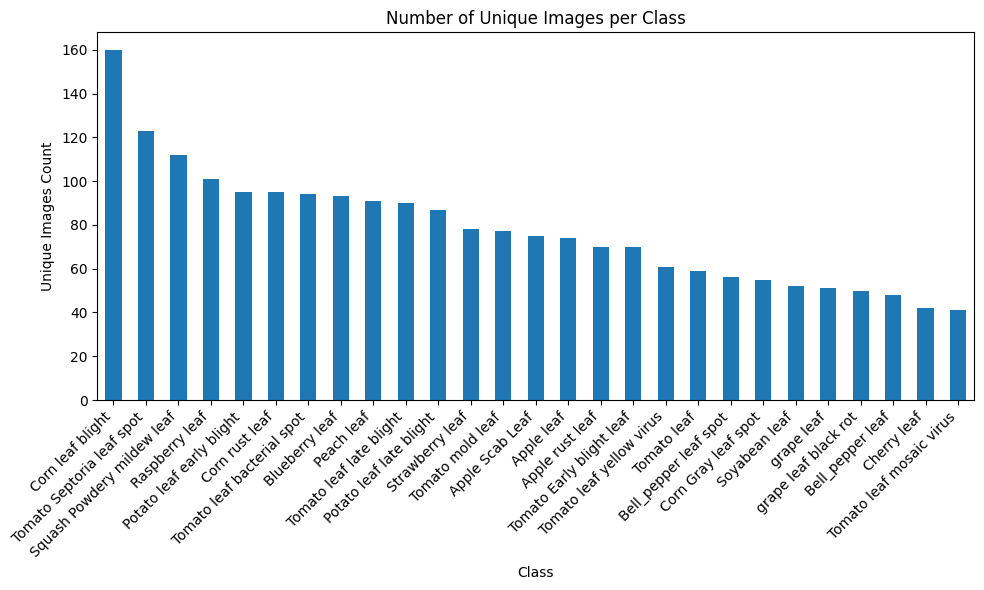

In [ ]:
img_per_class = train_annotations.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load the train_annotations.csv file
train_annotations = pd.read_csv('/content/train/train_annotations.csv')

# Display the first few rows to confirm
display(train_annotations.head())

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Faske%20Southern%20rust%20of%20corn_jpg.rf.016...,416,416,Corn rust leaf,235,2,415,344
1,Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b9...,416,416,Corn leaf blight,3,3,415,312
2,2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B...,416,416,Tomato leaf late blight,105,42,267,354
3,Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf42...,416,416,Apple Scab Leaf,151,35,256,390
4,Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf42...,416,416,Apple Scab Leaf,86,278,194,385


In [ ]:
from pathlib import Path
import glob
from collections import defaultdict

IMGS_TRAIN = Path("/content/train/images")
LABS_TRAIN = Path("/content/train/labels")

def read_yolo_txt(p):
    p = Path(p)
    boxes, labels = [], []
    if p.is_file():
        for ln in p.read_text().strip().splitlines():
            if not ln.strip(): continue
            c, cx, cy, w, h = ln.split()
            labels.append(int(c))
            boxes.append([float(cx), float(cy), float(w), float(h)])
    return boxes, labels

def image_classes(img_path):
    from pathlib import Path
    lp = LABS_TRAIN / (Path(img_path).stem + ".txt")
    _, labels = read_yolo_txt(lp)
    return set(labels)

# per-class counts (train فقط)
all_imgs = sum([glob.glob(str(IMGS_TRAIN/"**/*.jpg"), recursive=True),
                glob.glob(str(IMGS_TRAIN/"**/*.jpeg"), recursive=True),
                glob.glob(str(IMGS_TRAIN/"**/*.png"), recursive=True)], [])
cls2imgs = defaultdict(list)
for p in all_imgs:
    for c in image_classes(p):
        cls2imgs[c].append(p)

cls_counts = {c: len(v) for c,v in cls2imgs.items()}
target = max(cls_counts.values()) if cls_counts else 0
print("max(train):", target)
print("sample:", dict(list(sorted(cls_counts.items())[:10])))


max(train): 148
sample: {0: 71, 1: 72, 2: 66, 3: 46, 4: 48, 5: 91, 6: 35, 7: 44, 8: 148, 9: 82}


**Augmentation**

In [ ]:
missing = []
for p in all_imgs:
    lp = LABS_TRAIN / (Path(p).stem + ".txt")
    if not lp.is_file():
        missing.append((Path(p).name, str(lp)))
print("images without label:", len(missing))
print(missing[:10])


images without label: 148
[('22-late%20blight-advanced%20symptoms%20potato_jpg.rf.9fafb1e64da01db9de491dc8a0d1e0c3.jpg', '/content/train/labels/22-late%20blight-advanced%20symptoms%20potato_jpg.rf.9fafb1e64da01db9de491dc8a0d1e0c3.txt'), ('tomato%2Bseptoria%2Bleaf%2Bspot2_JPG_jpg.rf.93c8e9848fdc80f5246441fa6a820f2d.jpg', '/content/train/labels/tomato%2Bseptoria%2Bleaf%2Bspot2_JPG_jpg.rf.93c8e9848fdc80f5246441fa6a820f2d.txt'), ('Figure%201%20Common%20rust%20on%20a%20corn_jpg.rf.d98a6e285d146585cc68e4f62929c5c5.jpg', '/content/train/labels/Figure%201%20Common%20rust%20on%20a%20corn_jpg.rf.d98a6e285d146585cc68e4f62929c5c5.txt'), ('image_1500x1500%253E_jpeg?1472959493_jpg.rf.ed8360272f0839d67a6318c90c91b5bd.jpg', '/content/train/labels/image_1500x1500%253E_jpeg?1472959493_jpg.rf.ed8360272f0839d67a6318c90c91b5bd.txt'), ('raspberries_jpg.rf.6f265fc0cc6e20357544cda8c1e08794.jpg', '/content/train/labels/raspberries_jpg.rf.6f265fc0cc6e20357544cda8c1e08794.txt'), ('BCH%20medium%20thumbnail%20for%

In [ ]:
!pip install albumentations==1.4.8 opencv-python numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [ ]:
!pip install --upgrade albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.8
    Uninstalling albumentations-1.4.8:
      Successfully uninstalled albumentations-1.4.8


In [ ]:
'''import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.05, 0.05),
        rotate=(-10,10),   # ±10°
        shear=0,
        cval=114,
        p=0.7
    ),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.4),
    A.GaussianBlur(blur_limit=(3,5), p=0.1),
], bbox_params=A.BboxParams(
    format="yolo",
    label_fields=["class_labels"],
    min_visibility=0.30,
    clip=True  # باکس‌ها بیرون نرن؛ به [0,1] کلیپ می‌شن
))
'''

/tmp/ipython-input-2203412911.py:5: UserWarning: Argument(s) 'cval' are not valid for transform Affine
  A.Affine(


In [ ]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,     # ±5% جابه‌جایی
        scale_limit=0.10,     # ≈ 0.9..1.1
        rotate_limit=10,      # ±10°
        border_mode=0,        # constant
        value=114,            # مثل YOLO
        p=0.7
    ),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.4),
    A.GaussianBlur(blur_limit=(3,5), p=0.1),
], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"], min_visibility=0.30, clip=True))


**Dedicating tthe pathes**

In [ ]:
from pathlib import Path
import re, glob, hashlib
from collections import defaultdict

IMGS_TRAIN = Path("/content/train/images")
LABS_TRAIN  = Path("/content/train/labels")
IMGS_TRAIN.mkdir(parents=True, exist_ok=True)
LABS_TRAIN.mkdir(parents=True, exist_ok=True)

PER_IMAGE_CAP = 4
AUG_FILE_RE = re.compile(r"_aug(\d+)\.(jpg|jpeg|png)$", re.I)

# پیشوند امن/کوتاه (برای جلوگیری از File name too long)
SAFE_BASE_LEN = 40
def make_safe_prefix(src_img_path, max_base=SAFE_BASE_LEN):
    stem = Path(src_img_path).stem
    slug = re.sub(r'[^A-Za-z0-9._-]+', '-', stem)[:max_base]
    h = hashlib.sha1(stem.encode("utf-8")).hexdigest()[:8]
    return f"{slug}__{h}"

# همه‌ی تصاویر موجود (اصلی + آگو)
all_imgs = []
for ext in ("*.jpg","*.jpeg","*.png"):
    all_imgs += glob.glob(str(IMGS_TRAIN/"**"/ext), recursive=True)

# تصاویر «اصلی» = آن‌هایی که خودشان _aug ندارند
orig_imgs = [p for p in all_imgs if not AUG_FILE_RE.search(p)]

# کلید امن برای هر منبع اصلی
img_key = {p: make_safe_prefix(p) for p in orig_imgs}

# شمارش آگوهای موجود برای هر منبع
def count_existing_for_prefix(prefix: str) -> int:
    cnt = 0
    for ext in ("jpg","jpeg","png"):
        cnt += len(list(IMGS_TRAIN.glob(f"{prefix}_aug*.{ext}")))
    return cnt

aug_count = {img_key[p]: count_existing_for_prefix(img_key[p]) for p in orig_imgs}

# اندیس سراسری نام‌گذاری
def next_global_index():
    mx = -1
    for p in IMGS_TRAIN.glob("*"):
        m = AUG_FILE_RE.search(p.name)
        if m: mx = max(mx, int(m.group(1)))
    return mx + 1

GLOBAL_IDX = next_global_index()
print(f"Original images: {len(orig_imgs)} | Start idx: {GLOBAL_IDX}")


Original images: 2096 | Start idx: 238


**Function for reading and writing yolo labels**

In [ ]:
def read_yolo_txt(txt_path):
    txt_path = Path(txt_path)
    boxes, labels = [], []
    if not txt_path.is_file():
        return boxes, labels
    for ln in txt_path.read_text().strip().splitlines():
        if not ln.strip(): continue
        c, cx, cy, w, h = ln.split()
        labels.append(int(c))
        boxes.append([float(cx), float(cy), float(w), float(h)])
    return boxes, labels

def write_yolo_txt(txt_path, boxes, labels):
    txt_path = Path(txt_path)
    with txt_path.open("w") as f:
        for (cx,cy,w,h), c in zip(boxes, labels):
            f.write(f"{int(c)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

def sanitize_yolo_boxes(boxes, labels, eps=1e-6):
    """YOLO->[x1,y1,x2,y2]→کلمپ به [0,1]→حذف باکس‌های تهی→برگشت به YOLO."""
    clean_b, clean_l = [], []
    for (cx, cy, w, h), c in zip(boxes, labels):
        x1, y1 = cx - w/2.0, cy - h/2.0
        x2, y2 = cx + w/2.0, cy + h/2.0
        x1 = max(0.0, min(1.0, x1)); y1 = max(0.0, min(1.0, y1))
        x2 = max(0.0, min(1.0, x2)); y2 = max(0.0, min(1.0, y2))
        w2, h2 = (x2 - x1), (y2 - y1)
        if w2 <= eps or h2 <= eps:  # باکس حذف می‌شود
            continue
        cx2, cy2 = x1 + w2/2.0, y1 + h2/2.0
        clean_b.append([cx2, cy2, w2, h2]); clean_l.append(c)
    return clean_b, clean_l


**Making Augmentation for training label**

In [ ]:
import cv2

def save_aug_pair(src_img_path, aug_img, aug_boxes, aug_labels):
    global GLOBAL_IDX
    key = img_key.get(src_img_path, make_safe_prefix(src_img_path))
    out_img = IMGS_TRAIN / f"{key}_aug{GLOBAL_IDX:05d}.jpg"
    out_lab = LABS_TRAIN  / f"{key}_aug{GLOBAL_IDX:05d}.txt"
    GLOBAL_IDX += 1

    cv2.imwrite(str(out_img), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
    write_yolo_txt(out_lab, aug_boxes, aug_labels)

    aug_count[key] = aug_count.get(key, 0) + 1


In [ ]:
import cv2
from pathlib import Path

def augment_one_image_with_cap(src_img_path, k=1, max_tries=6):
    key = img_key.get(src_img_path, make_safe_prefix(src_img_path))
    quota = PER_IMAGE_CAP - aug_count.get(key, 0)
    if quota <= 0:
        return 0

    img = cv2.cvtColor(cv2.imread(str(src_img_path)), cv2.COLOR_BGR2RGB)
    lab_path = LABS_TRAIN / (Path(src_img_path).stem + ".txt")
    bboxes, labels = read_yolo_txt(lab_path)
    if len(labels) == 0:
        return 0

    bboxes, labels = sanitize_yolo_boxes(bboxes, labels)
    if len(labels) == 0:
        return 0

    saved = 0
    for _ in range(min(k, quota)):
        tries = 0
        while tries < max_tries:
            out = transform(image=img, bboxes=bboxes, class_labels=labels)
            aug_img    = out["image"]
            aug_boxes  = out["bboxes"]
            aug_labels = out["class_labels"]
            if len(aug_boxes) > 0:
                save_aug_pair(src_img_path, aug_img, aug_boxes, aug_labels)
                saved += 1
                break
            tries += 1
    return saved


In [ ]:
import glob
from collections import defaultdict

# همه‌ی تصاویر فعلی (اصلی + آگو)
all_imgs = []
for ext in ("*.jpg","*.jpeg","*.png"):
    all_imgs += glob.glob(str(IMGS_TRAIN/"**"/ext), recursive=True)

def image_classes(img_path):
    lp = LABS_TRAIN / (Path(img_path).stem + ".txt")
    _, labels = read_yolo_txt(lp)
    return set(labels)

cls2imgs_all = defaultdict(list)
for p in all_imgs:
    for c in image_classes(p):
        cls2imgs_all[c].append(p)

cls_counts = {c: len(v) for c, v in cls2imgs_all.items()}
if not cls_counts:
    raise SystemExit("هیچ لیبلی پیدا نشد.")
target = max(cls_counts.values())
print("شمارش فعلی:", cls_counts)
print("هدف (بزرگ‌ترین کلاس):", target)


شمارش فعلی: {8: 148, 20: 84, 0: 71, 22: 148, 2: 66, 23: 59, 4: 48, 7: 148, 25: 51, 11: 87, 16: 77, 13: 98, 21: 83, 18: 112, 5: 91, 24: 69, 17: 63, 1: 72, 26: 48, 15: 109, 12: 86, 14: 48, 6: 58, 9: 82, 19: 58, 10: 91, 3: 46}
هدف (بزرگ‌ترین کلاس): 148


In [ ]:
# فقط تصاویر اصلی (بدون _aug) منبع تولید هستند
orig_imgs = [p for p in all_imgs if not AUG_FILE_RE.search(p)]

cls2orig_sources = defaultdict(list)
for p in orig_imgs:
    for c in image_classes(p):
        cls2orig_sources[c].append(p)

def remaining_quota(src_img_path):
    k = img_key.get(src_img_path, make_safe_prefix(src_img_path))
    return max(0, PER_IMAGE_CAP - aug_count.get(k, 0))

def max_reachable(c):
    return cls_counts.get(c, 0) + sum(remaining_quota(p) for p in cls2orig_sources[c])

for c in sorted(cls_counts, key=lambda x: cls_counts[x]):
    print(f"کلاس {c}: الان {cls_counts[c]} | سقف قابل‌دستیابی {max_reachable(c)} | هدف {target}")


کلاس 3: الان 46 | سقف قابل‌دستیابی 230 | هدف 148
کلاس 4: الان 48 | سقف قابل‌دستیابی 240 | هدف 148
کلاس 26: الان 48 | سقف قابل‌دستیابی 225 | هدف 148
کلاس 14: الان 48 | سقف قابل‌دستیابی 240 | هدف 148
کلاس 25: الان 51 | سقف قابل‌دستیابی 255 | هدف 148
کلاس 6: الان 58 | سقف قابل‌دستیابی 198 | هدف 148
کلاس 19: الان 58 | سقف قابل‌دستیابی 280 | هدف 148
کلاس 23: الان 59 | سقف قابل‌دستیابی 295 | هدف 148
کلاس 17: الان 63 | سقف قابل‌دستیابی 315 | هدف 148
کلاس 2: الان 66 | سقف قابل‌دستیابی 330 | هدف 148
کلاس 24: الان 69 | سقف قابل‌دستیابی 345 | هدف 148
کلاس 0: الان 71 | سقف قابل‌دستیابی 355 | هدف 148
کلاس 1: الان 72 | سقف قابل‌دستیابی 360 | هدف 148
کلاس 16: الان 77 | سقف قابل‌دستیابی 385 | هدف 148
کلاس 9: الان 82 | سقف قابل‌دستیابی 410 | هدف 148
کلاس 21: الان 83 | سقف قابل‌دستیابی 415 | هدف 148
کلاس 20: الان 84 | سقف قابل‌دستیابی 420 | هدف 148
کلاس 12: الان 86 | سقف قابل‌دستیابی 430 | هدف 148
کلاس 11: الان 87 | سقف قابل‌دستیابی 435 | هدف 148
کلاس 5: الان 91 | سقف قابل‌دستیابی 455 | هدف 148
کلاس 10:

In [ ]:
from tqdm import tqdm
import cv2

def try_augment_keep_class(src_img_path, target_class, tries=8):
    img = cv2.cvtColor(cv2.imread(str(src_img_path)), cv2.COLOR_BGR2RGB)
    lab_path = LABS_TRAIN / (Path(src_img_path).stem + ".txt")
    bboxes, labels = read_yolo_txt(lab_path)
    if len(labels) == 0 or target_class not in labels:
        return None
    bboxes, labels = sanitize_yolo_boxes(bboxes, labels)
    if len(labels) == 0 or target_class not in labels:
        return None

    for _ in range(tries):
        out = transform(image=img, bboxes=bboxes, class_labels=labels)
        aug_img, aug_boxes, aug_labels = out["image"], out["bboxes"], out["class_labels"]
        if len(aug_boxes) > 0 and target_class in aug_labels:
            return aug_img, aug_boxes, aug_labels
    return None

total_added = 0

# از کلاس‌های کم‌تعدادتر شروع کن
for c in tqdm(sorted(cls_counts, key=lambda x: cls_counts[x]), desc="Balancing"):
    eff_target = min(target, max_reachable(c))
    if cls_counts[c] >= eff_target:
        continue

    # منابع این کلاس را بر اساس سهمیه باقیمانده مرتب کن (بیشترین quota اول)
    src_list = sorted(cls2orig_sources[c], key=lambda p: remaining_quota(p), reverse=True)
    ptr, stalled = 0, 0

    while cls_counts[c] < eff_target and src_list and stalled < len(src_list)*3:
        src = src_list[ptr % len(src_list)]
        ptr += 1

        if remaining_quota(src) <= 0:
            stalled += 1
            continue

        res = try_augment_keep_class(src, target_class=c, tries=8)
        if res is None:
            stalled += 1
            continue

        aug_img, aug_boxes, aug_labels = res
        save_aug_pair(src, aug_img, aug_boxes, aug_labels)  # ذخیره + بروزرسانی aug_count
        total_added += 1

        # به‌روز کردن شمارش‌ها برای همه‌ی کلاس‌های موجود در خروجی جدید
        for cc in set(aug_labels):
            cls_counts[cc] = cls_counts.get(cc, 0) + 1

        stalled = 0  # چون پیش رفتیم
print("نمونه‌های افزوده‌شده برای بالانس:", total_added)


Balancing: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]

نمونه‌های افزوده‌شده برای بالانس: 1777


In [ ]:
print("شمارش نهایی هر کلاس:", cls_counts)
print("کمترین/بیشترین:", min(cls_counts.values()), "/", max(cls_counts.values()))


شمارش نهایی هر کلاس: {8: 148, 20: 148, 0: 148, 22: 149, 2: 148, 23: 148, 4: 148, 7: 148, 25: 148, 11: 148, 16: 148, 13: 148, 21: 148, 18: 148, 5: 148, 24: 148, 17: 148, 1: 148, 26: 148, 15: 148, 12: 149, 14: 148, 6: 148, 9: 148, 19: 154, 10: 148, 3: 148}
کمترین/بیشترین: 148 / 154


In [ ]:
import os
from collections import defaultdict

# Define the path to the training labels directory
train_label_dir = '/content/train/labels'

# Dictionary to store class counts based on label files
image_counts_from_labels = defaultdict(int)

# Load the class names from the classes.txt file
classes_file = '/content/train/labels/classes.txt'
class_names = []
try:
    with open(classes_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
except FileNotFoundError:
    print(f"Error: {classes_file} not found. Cannot map class IDs to names.")
    # If classes.txt is not found, we'll just use class IDs

# Iterate through label files in the training labels directory
for label_file in os.listdir(train_label_dir):
    if label_file.endswith('.txt') and not label_file == 'classes.txt':
        label_path = os.path.join(train_label_dir, label_file)
        try:
            with open(label_path, 'r') as f:
                # Assuming one class per image for simplicity in counting unique images
                # If an image has multiple objects of different classes, this will only count one.
                # A more precise count would iterate through all annotations in all files.
                # However, for verifying if we reached 200 *images* per class, this is a reasonable approach.
                first_line = f.readline().strip()
                if first_line:
                    class_id = int(first_line.split()[0])
                    # Map class ID to name if class_names were loaded, otherwise use ID
                    class_identifier = class_names[class_id] if class_names and class_id < len(class_names) else f"Class ID {class_id}"
                    image_counts_from_labels[class_identifier] += 1
        except Exception as e:
            print(f"Error reading label file {label_file}: {e}")

print("Number of unique images per class based on label files:")
# Sort by class name for consistent output
for class_name in sorted(image_counts_from_labels.keys()):
    count = image_counts_from_labels[class_name]
    print(f"- {class_name}: {count}")

Number of unique images per class based on label files:
- Apple Scab Leaf: 152
- Apple leaf: 150
- Apple rust leaf: 152
- Bell_pepper leaf: 150
- Bell_pepper leaf spot: 156
- Blueberry leaf: 150
- Cherry leaf: 155
- Corn Gray leaf spot: 159
- Corn leaf blight: 160
- Corn rust leaf: 161
- Peach leaf: 148
- Potato leaf early blight: 154
- Potato leaf late blight: 148
- Raspberry leaf: 151
- Soyabean leaf: 152
- Squash Powdery mildew leaf: 151
- Strawberry leaf: 149
- Tomato Early blight leaf: 155
- Tomato Septoria leaf spot: 159
- Tomato leaf: 131
- Tomato leaf bacterial spot: 153
- Tomato leaf late blight: 152
- Tomato leaf mosaic virus: 146
- Tomato leaf yellow virus: 150
- Tomato mold leaf: 156
- grape leaf: 148
- grape leaf black rot: 153


# **Modeling**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolo12n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU name: Tesla T4


In [ ]:
model.train(
    data='/content/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,         # auto
    optimizer='Adam',
    device=0, # or 'SGD', 'Adam', etc.
    augment=True, # Enable augmentation
    album=transform # Pass the albumentations transform
)

Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

Overriding model.yaml nc=80 with nc=27

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytic

 20                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 21        [14, 17, 20]  1    435937  ultralytics.nn.modules.head.Detect           [27, [64, 128, 256]]          
YOLOv12n summary: 272 layers, 2,573,313 parameters, 2,573,297 gradients, 6.5 GFLOPs

Transferred 640/691 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 897.9±481.5 MB/s, size: 30.1 KB)


train: Scanning /content/train/labels... 1948 images, 148 backgrounds, 0 corrupt: 100%|██████████| 2096/2096 [00:01<00:00, 2009.99it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 375.0±133.9 MB/s, size: 26.8 KB)


val: Scanning /content/validation/labels... 218 images, 14 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<00:00, 920.40it/s]

val: New cache created: /content/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.34G      1.758      4.035      1.863         98        640: 100%|██████████| 131/131 [00:57<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]

                   all        232        788      0.409     0.0526    0.00209   0.000624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.74G      1.821      3.808      1.969        113        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        232        788      0.649      0.031    0.00458    0.00187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.75G      1.816      3.755      1.938         86        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


                   all        232        788      0.166      0.135     0.0107    0.00524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.77G       1.76      3.657      1.933         85        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        232        788       0.56     0.0156    0.00207   0.000973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.78G      1.724      3.601      1.882         96        640: 100%|██████████| 131/131 [00:42<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


                   all        232        788      0.308       0.12     0.0144    0.00645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.8G      1.684      3.531      1.844        122        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


                   all        232        788      0.325      0.131     0.0422     0.0225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.81G      1.632      3.476       1.81         66        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


                   all        232        788      0.543     0.0782     0.0309     0.0152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.83G      1.621      3.372      1.806         82        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


                   all        232        788      0.469      0.132     0.0514      0.028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.84G      1.588      3.372      1.767         79        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        232        788      0.438       0.16     0.0522     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.86G      1.596      3.319      1.765         93        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

                   all        232        788      0.379      0.128     0.0565     0.0317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.87G      1.584      3.287      1.751         70        640: 100%|██████████| 131/131 [00:43<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]

                   all        232        788      0.384      0.135     0.0593     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.88G      1.561      3.278      1.742        103        640: 100%|██████████| 131/131 [00:46<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.79it/s]


                   all        232        788      0.481      0.157      0.078     0.0444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       3.9G      1.559      3.269       1.75         89        640: 100%|██████████| 131/131 [00:45<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


                   all        232        788      0.451      0.132     0.0608     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.91G      1.578      3.227      1.763        126        640: 100%|██████████| 131/131 [00:45<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.42it/s]


                   all        232        788      0.402      0.144     0.0679     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.93G       1.55      3.197      1.731        140        640: 100%|██████████| 131/131 [00:47<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

                   all        232        788      0.644      0.143     0.0929     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.94G       1.52      3.143      1.691         98        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        232        788       0.35      0.146     0.0868     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.96G      1.509      3.124      1.695         53        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        232        788      0.433      0.136     0.0708     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.97G      1.521      3.146       1.71        116        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


                   all        232        788      0.364      0.162     0.0853     0.0493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.99G      1.514      3.107      1.679         96        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.304      0.154     0.0741     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         4G      1.509      3.099      1.696        102        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]


                   all        232        788       0.41      0.163     0.0773     0.0415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.02G      1.512      3.053      1.687         65        640: 100%|██████████| 131/131 [00:42<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]

                   all        232        788      0.202       0.17     0.0914     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.03G      1.494      3.057      1.688         97        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


                   all        232        788      0.246      0.193     0.0904     0.0524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.05G      1.487       3.05      1.669        107        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]


                   all        232        788      0.274      0.152     0.0659     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.06G      1.473      3.021      1.655        123        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.402      0.154     0.0883      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.08G      1.485      3.006      1.666         87        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

                   all        232        788      0.252      0.179      0.101     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.09G      1.484      3.013       1.68        148        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        232        788      0.322      0.202      0.111     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.11G      1.454      2.948      1.643         87        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

                   all        232        788      0.326      0.194      0.101     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.12G      1.478      2.961       1.67        132        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]


                   all        232        788      0.426      0.227     0.0989     0.0573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.14G      1.465      2.933       1.66         97        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788      0.341      0.162      0.112     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.15G      1.446      2.896      1.636         70        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.236      0.165      0.112     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.17G      1.454      2.907       1.64         83        640: 100%|██████████| 131/131 [00:45<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.181      0.216      0.111     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.18G      1.458      2.914      1.645         70        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]


                   all        232        788      0.222      0.231       0.12     0.0734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       4.2G      1.431      2.863       1.63        105        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


                   all        232        788      0.248      0.229      0.124      0.076

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.21G      1.449      2.863      1.647         94        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

                   all        232        788      0.325      0.238      0.127     0.0748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.23G       1.44      2.837      1.628         77        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788       0.24      0.208      0.117      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.24G      1.463      2.831      1.651        110        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        232        788      0.179       0.25      0.149     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.26G      1.434      2.805      1.626         81        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]

                   all        232        788      0.177      0.243      0.135     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.27G       1.44      2.809      1.643         67        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

                   all        232        788       0.27      0.211      0.126     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.29G      1.445      2.792      1.632         88        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        232        788      0.216      0.238      0.129     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       4.3G      1.416      2.764       1.62        101        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]

                   all        232        788      0.242      0.245      0.139     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.31G      1.412      2.735      1.613         92        640: 100%|██████████| 131/131 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        232        788      0.191      0.233       0.14      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.33G       1.41      2.729      1.612        103        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]

                   all        232        788       0.21       0.24      0.125     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.35G      1.412      2.727      1.617        105        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        232        788      0.174      0.239      0.133     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.36G      1.395      2.687        1.6         64        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        232        788       0.19      0.285      0.172       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.38G      1.401       2.73      1.617         97        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

                   all        232        788      0.167      0.263      0.161      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.39G      1.405        2.7      1.605         85        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.257      0.247      0.157     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       4.4G      1.391      2.715      1.622         90        640: 100%|██████████| 131/131 [00:42<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        232        788      0.115      0.271      0.148     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.42G      1.395      2.686      1.614         88        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

                   all        232        788      0.149      0.234      0.143     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.43G      1.396      2.689      1.592        160        640: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]

                   all        232        788      0.195      0.243      0.156     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.45G      1.403      2.665       1.61        100        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]


                   all        232        788      0.172      0.285      0.164      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.46G      1.407       2.64      1.602         90        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788      0.151      0.322      0.178      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.48G      1.378      2.619      1.583         83        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.286      0.269      0.135     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.49G      1.371       2.65      1.591         74        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

                   all        232        788      0.162      0.307      0.172      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.51G      1.392      2.641      1.586        113        640: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        232        788      0.196      0.285      0.192      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.52G      1.373      2.614      1.589         86        640: 100%|██████████| 131/131 [00:43<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        232        788      0.172      0.316      0.191      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.54G      1.377      2.594      1.584         91        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        232        788      0.156      0.324      0.204      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.55G      1.379      2.591       1.59         92        640: 100%|██████████| 131/131 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


                   all        232        788      0.177      0.299      0.183      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.57G      1.372      2.582      1.582        103        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.206      0.326      0.206      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.58G      1.366      2.557       1.57         76        640: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        232        788      0.211      0.257      0.172      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       4.6G      1.379      2.569      1.583         94        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        232        788      0.202      0.268      0.197      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.61G      1.362      2.538      1.577         88        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

                   all        232        788      0.223      0.296      0.196      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.63G      1.345      2.527      1.555         80        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

                   all        232        788      0.156      0.359      0.224      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.64G      1.366      2.523      1.569        114        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

                   all        232        788      0.177      0.336      0.232      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.66G      1.354      2.509      1.567        150        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.195      0.295      0.204      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.67G      1.355      2.471      1.561         89        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]


                   all        232        788       0.18      0.343      0.212      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.69G      1.325      2.444      1.543         87        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        232        788      0.163       0.33      0.214      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       4.7G      1.344      2.474      1.558        103        640: 100%|██████████| 131/131 [00:44<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        232        788      0.271      0.273      0.196       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.71G      1.327      2.417       1.54         87        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

                   all        232        788      0.196      0.384      0.231       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.73G      1.347      2.435      1.556        139        640: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        232        788      0.194      0.345      0.225      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.75G      1.346      2.431      1.564         70        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


                   all        232        788      0.187       0.35       0.22      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.76G      1.334      2.418      1.544        120        640: 100%|██████████| 131/131 [00:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        232        788      0.341      0.256      0.225      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.78G      1.325      2.416      1.538        102        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


                   all        232        788      0.185      0.362      0.232      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.79G      1.348      2.409      1.554        102        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        232        788      0.201      0.321      0.237      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       4.8G      1.334      2.399      1.545         87        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

                   all        232        788      0.185      0.331      0.225      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.82G      1.309      2.365      1.534         84        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]

                   all        232        788      0.178      0.384      0.243      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.83G      1.316      2.389       1.53         96        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

                   all        232        788      0.174       0.32      0.241      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.85G      1.319      2.364      1.529         78        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.189      0.305      0.231      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.86G      1.295      2.339      1.521         94        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

                   all        232        788      0.229      0.342      0.257      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.88G      1.305      2.323      1.523         93        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.228      0.355      0.243      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G      1.296      2.324      1.513         96        640: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        232        788      0.274      0.297      0.214      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.91G      1.314      2.332      1.525         76        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.206       0.37      0.252      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.92G      1.293      2.307       1.51        112        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        232        788       0.21      0.348      0.268       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.94G       1.29      2.298      1.512         84        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        232        788      0.228      0.331      0.258      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.95G       1.29      2.277      1.514         66        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.234      0.381      0.278       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.97G      1.264      2.263      1.493         91        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

                   all        232        788      0.242      0.364      0.276       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.98G      1.265       2.22      1.487        132        640: 100%|██████████| 131/131 [00:44<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        232        788      0.215      0.353      0.275      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         5G      1.306      2.245      1.514        101        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.73it/s]


                   all        232        788      0.232      0.365      0.283      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.01G      1.282      2.239        1.5        103        640: 100%|██████████| 131/131 [00:44<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        232        788      0.299      0.368      0.285      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.03G      1.261      2.226      1.488         80        640: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        232        788      0.281      0.365      0.284      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.04G      1.263      2.178      1.492         80        640: 100%|██████████| 131/131 [00:44<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        232        788      0.256      0.341      0.296      0.194


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.06G      1.243      2.171      1.532         52        640: 100%|██████████| 131/131 [00:45<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        232        788      0.291      0.362      0.291      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.07G       1.23      2.109      1.517         56        640: 100%|██████████| 131/131 [00:42<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        232        788      0.254      0.404      0.301        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.09G      1.222      2.084      1.513         42        640: 100%|██████████| 131/131 [00:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        232        788      0.241      0.414      0.306      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       5.1G      1.221      2.031      1.512         64        640: 100%|██████████| 131/131 [00:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        232        788      0.265      0.407      0.308      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G      1.209      2.018      1.499         59        640: 100%|██████████| 131/131 [00:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.295      0.388      0.318      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.13G      1.212      1.999      1.507         35        640: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

                   all        232        788      0.298      0.387      0.316      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.15G      1.208      1.977      1.499         89        640: 100%|██████████| 131/131 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        232        788      0.288      0.364      0.323      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.16G      1.195      1.961      1.493         49        640: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]

                   all        232        788      0.296      0.369      0.319      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.18G      1.199      1.968      1.501         16        640: 100%|██████████| 131/131 [00:42<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        232        788      0.275      0.381      0.319      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.19G      1.185      1.937      1.483         25        640: 100%|██████████| 131/131 [00:42<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        232        788      0.297       0.38       0.33      0.226



100 epochs completed in 1.303 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,561,993 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        232        788      0.297       0.38       0.33      0.226
       Apple Scab Leaf          6         10     0.0753        0.1     0.0564     0.0418
            Apple leaf          8         29      0.593      0.724       0.74      0.539
       Apple rust leaf          8         17       0.42      0.235      0.251      0.129
      Bell_pepper leaf          5         52      0.323     0.0962      0.213      0.123
 Bell_pepper leaf spot          6         22          0          0       0.11     0.0746
        Blueberry leaf         10         51      0.288      0.529      0.399      0.263
           Cherry leaf          4         18          0          0     0.0407     0.0278
   Corn Gray leaf spot          6          6      0.422      0.833      0.576      0.368
      Corn leaf blight         17         38      0.441      0.605       0.49      0.254
        Corn rust leaf         11         13      0.434      0.692      0.678      0.525
            Peach lea

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c68b08b6c00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0